In [2]:
import pandas as pd
import numpy as np
import math 
import os 
from datetime import datetime, timedelta
import pymap3d # python3 -m pip install pymap3d
import random
import pickle
from scipy.special import lambertw
from scipy import stats
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from bokeh.plotting import figure, show, output_notebook, output_file, reset_output, save
from bokeh.layouts import gridplot, row, column
from bokeh.models import Range1d
output_notebook() 
# output_notebook() 

save_data_bool = False # Save data or not

Loading BokehJS ...

## Import data

In [3]:
dataset="cabspotting" # OPTIONS ARE: cabspotting privamov
user="oilrag" # Examples: abboip oilrag 51 90 14

In [4]:
local_url="datasets/"+dataset+"-tree/"+user+".csv"
sol_file='sol_04112022_H30'
exists = os.path.isfile(local_url)
if exists:
    data = pd.read_csv(local_url,names=["latitude","longitude","timestamp"])
    print("uploaded from local file")
else:
    print("data not found")
#[x,y,time]=import_trace(dataset,user)


if not os.path.exists(sol_file):
    os.makedirs(sol_file)

    

uploaded from local file


In [5]:
data['time']=[datetime.utcfromtimestamp(tstamp/1000) for tstamp in data['timestamp']]
data['elapsedtime']=(data['timestamp']-data['timestamp'][0])/1000
whole_duration = data['elapsedtime'][len(data['timestamp'])-1]/60
print('Whole duration: '+str(math.floor(whole_duration))+' min')

Whole duration: 1126 min


In [6]:
data=data.set_index('time').sort_index().copy()
ell_grs80 = pymap3d.Ellipsoid('grs80') 
data['altitude']=np.zeros(len(data.index))
lat0, lon0, h0 = data['latitude'][0],data['longitude'][0],data['altitude'][0]
data['x'], data['y'], data['u_enu'] = pymap3d.geodetic2enu(data['latitude'], data['longitude'], data['altitude'], lat0, lon0, h0, ell=ell_grs80)
data.head()

,latitude,longitude,timestamp,elapsedtime,altitude,x,y,u_enu
time,,,,,,,,
2008-05-17 10:00:06,37.74574,-122.42685,1211018406000,0.0,0.0,0.000000,0.000000,0.000000
2008-05-17 10:01:17,37.74967,-122.42729,1211018477000,71.0,0.0,-38.777282,436.197503,-0.015077
2008-05-17 10:03:13,37.75233,-122.43419,1211018593000,187.0,0.0,-646.852405,731.460882,-0.074827
2008-05-17 10:04:03,37.75696,-122.43463,1211018643000,237.0,0.0,-685.585574,1245.356220,-0.158740
2008-05-17 10:05:13,37.76122,-122.43501,1211018713000,307.0,0.0,-719.030524,1718.184648,-0.272590


Code for resampling the data: for every ts-long interval, $[i t_s, \ (i+1) t_s ]$, the mean of the transmitted data is computed and associated to the smpling instant $(i+1) t_s$.

In [7]:
# Real transmitted data
Tmin = 0
Tmax = 5000
# Tmax = data['elapsedtime'][-1]
xr = data['x'][(data['elapsedtime'] >= Tmin) & (data['elapsedtime'] < Tmax)]
yr = data['y'][(data['elapsedtime'] >= Tmin) & (data['elapsedtime'] < Tmax)]
ur = data['u_enu'][(data['elapsedtime'] >= Tmin) & (data['elapsedtime'] < Tmax)]
Timer = data['elapsedtime'][(data['elapsedtime'] >= Tmin) & (data['elapsedtime'] < Tmax)]

Arthur: u_enu c'est les up coordinate . Et on se limite de 0 à Tmax

In [8]:
#Arthur: je flairise
erreur = 5*1e-2 #à préciser


def FLAIR_PMRD(data, mode, epsilon):
    """transforms the mobility data of the different users just as in the FLAIR paper

    Args:
        data (dataframe): the data
        mode(str): either 'x', 'y', or "u_enu"
        epsilon(float): FLAIR's epsilon
    """
    
    X = [] #stockera les points conservés
    Ax = [] #stockera les coefs directeurs
    Tx = [] #stockera le temps associé aux points conservés
    t_min = data['timestamp'][0]
    
    if data[mode].shape[0] >= 2: #bon en pratique ça arrive jamais
            x0 = data[mode][0]
            x1 = data[mode][1]
            t0 = (data['timestamp'][0] - t_min) / 1000 #je mets tout en seconde -> je viens de me rendre compte que elapsed time fait déjà tout ça :)
            t1 = (data['timestamp'][1] - t_min) /1000
            A0_x = (x1-x0)/(t1-t0 +1e-12) #sur certains datasets ça peut arriver qu'on ait deux fois le même temps mais ici on
            #pourrait très bien enlever le 1e-12
            A_min_x = (x1-epsilon-x0)/(t1-t0 +1e-12)
            A_max_x = (x1+epsilon-x0)/(t1-t0 +1e-12)
            for i in range (2,data.shape[0]):
                x = data[mode][i]
                t = (data['timestamp'][i] - t_min)/ 1000
                x0, t0, x1, t1, A0_x, A_min_x, A_max_x = FLAIR_insert_1d(x0, x1, x, t0, t1, t, A0_x, A_min_x, A_max_x, X, Ax, Tx, epsilon)
            X.append(x0)
            Ax.append(A0_x)
            Tx.append(t0)
    return(X,Ax,Tx)


def FLAIR_insert_1d(x0, x1, x, t0, t1, t, A0, A_min, A_max, S, A, T, epsilon):
    """Inserts a new sample (x,t) into the previous model if possible. Creates a new model otherwise.

    Args:
        x0 (_type_): first sample of the last model
        x1 (_type_): last sample of the last model
        x (_type_): sample to be inserted
        t0 (_type_): first time..
        t1 (_type_): _description_
        t (_type_): _description_
        A0 (_type_): linear coef of the current model
        A_min (_type_): _description_
        A_max (_type_): _description_
        S (_type_): stores x
        A (_type_): stores linear coefs
        T (_type_): stores time

    Returns:
        _type_: _description_
    """
    x_delta, t_delta = x -x0, t - t0
    
    A_t = x_delta/(t_delta+1e-8)
    if A_min <= A_t and A_t <= A_max:
        
        A0 = A_t
        A_min = max(A_min, (x_delta-epsilon)/(t_delta + 1e-12))
        A_max = min(A_max, (x_delta+epsilon)/(t_delta + 1e-12))
    else: 
        S.append(x0)
        A.append(A0)
        T.append(t0)
        t0 = t
        x0, t0 = x1, t1
        x_delta, t_delta = x -x0, t -t0
        A0 = x_delta/(t_delta+1e-12)
        A_min = (x_delta-epsilon)/(t_delta + 1e-12)
        A_max = (x_delta+epsilon)/(t_delta + 1e-12)
    x1, t1 = x, t 
    return (x0, t0, x1, t1, A0, A_min, A_max)

In [9]:
data_timed = data[(data['elapsedtime'] >= Tmin) & (data['elapsedtime'] < Tmax)]
X_FLAIR, Ax_FLAIR, Tx_FLAIR = FLAIR_PMRD(data_timed, 'x', erreur)
Y_FLAIR, Ay_FLAIR, Ty_FLAIR = FLAIR_PMRD(data_timed, 'y', erreur)
U_FLAIR, Au_FLAIR, Tu_FLAIR = FLAIR_PMRD(data_timed, 'u_enu', erreur)

print('x old shape: ' + str(data_timed['x'].shape[0]) + '. x new shape: ' + str(len(X_FLAIR)) + '! \n')
print('y old shape: ' + str(data_timed['y'].shape[0]) + '. x new shape: ' + str(len(Y_FLAIR)) + '! \n')
print('u old shape: ' + str(data_timed['u_enu'].shape[0]) + '. x new shape: ' + str(len(U_FLAIR)) + '! \n')

x old shape: 81. x new shape: 77! 

y old shape: 81. x new shape: 80! 

u old shape: 81. x new shape: 34! 



Arthur: Pas de grande surpise, l'epsilon qui marchait pour lat/ long est beaucoup trop faible une fois qu'on passe en coordonnées geo_3d (en mètres), on conserve quasiment exactement la même trajectoire. À noter qu'on aura sans doute besoin d'un epsilon différent pour u et pour x/y, vu la différence des valeurs. (Comme à priori on se sert surtout du x,y sur ce notebook, je m'en occupe pas pour l'instant).

In [10]:
erreur = 3e+2
#on peut faire un ratio sur l'amplitude pour avoir un epsilon équivalent pour lat/ long
X_FLAIR, Ax_FLAIR, Tx_FLAIR = FLAIR_PMRD(data_timed, 'x', erreur)
Y_FLAIR, Ay_FLAIR, Ty_FLAIR = FLAIR_PMRD(data_timed, 'y', erreur)
U_FLAIR, Au_FLAIR, Tu_FLAIR = FLAIR_PMRD(data_timed, 'u_enu', erreur)

print('x old shape: ' + str(data_timed['x'].shape[0]) + '. x new shape: ' + str(len(X_FLAIR)) + '! \n')
print('y old shape: ' + str(data_timed['y'].shape[0]) + '. x new shape: ' + str(len(Y_FLAIR)) + '! \n')
print('u old shape: ' + str(data_timed['u_enu'].shape[0]) + '. x new shape: ' + str(len(U_FLAIR)) + '! \n')

x old shape: 81. x new shape: 17! 

y old shape: 81. x new shape: 12! 

u old shape: 81. x new shape: 1! 



On va regarder ce que ça donne pour la suite avec epsilon = 1000. On garde à peu près 1 sample sur 20, à voir si ça suffit.

In [11]:
# Resampling the data with sample time ts, averaging over the intervals
ts = 30  # Sampling time
tmax = Timer[-1]  # Final time 
nt = int(tmax/ts)+1
print(nt)

newx = []
newy = []
newu = []
newb = []
newTimer = []
for i in range(0,nt):
    xt = data['x'][(data['elapsedtime'] >= i*ts) & (data['elapsedtime'] < (i+1)*ts)].mean() 
    yt = data['y'][(data['elapsedtime'] >= i*ts) & (data['elapsedtime'] < (i+1)*ts)].mean() 
    ut = data['u_enu'][(data['elapsedtime'] >= i*ts) & (data['elapsedtime'] < (i+1)*ts)].mean() 
    if np.isnan(xt) == False:
        newx += [xt]
        newy += [yt]
        newu += [ut]
        newb += [1]
    else:  # Fill with zeros when no transmitted
        newx += [0]
        newy += [0]
        newu += [0]
        newb += [0]
    newTimer += [(i+1)*ts]

xs = np.array(newx)
ys = np.array(newy)
bs = np.array(newb)
us = np.array(newu)
Time = np.array(newTimer)


160


Arthur: et bs c'est 1 si transmis 0 sinon à priori

Attention, on va jusqu'à Timer[-1], et pas T_max = 5000, donc on s'arrête quand la traj s'arrête.

Arthur: isnan(xt) -> on aurait pas de données pendant cet intervalle, auquel cas on met 0 partout si c'est pas transmis.
Et donc effectivement ils harmonisent les fréquences de sampling, de sorte à avoir 30s tout le temps


Arthur: La question c'est quand est-ce qu'on FLAIRise la trajectoire (Pour l'instant on a utilisé FLAIR sur la trajectoire brute, à voir si plus tard on sera amené à plutôt FLAIRiser la trajectoire harmonisée (celle qui fait les moyennes des samples toutes les 30s, donc xs ici je le dis 'harmonisé'))

In [11]:
save_data_raw = pd.DataFrame()
save_data_raw['Timer'] = Timer
save_data_raw['xr'] = xr
save_data_raw['yr'] = yr
pickle.dump( save_data_raw, open( sol_file+"/save_data_raw.pkl", "wb" ) )

save_data = pd.DataFrame()
save_data['Time'] = Time
save_data['xs'] = xs
save_data['ys'] = ys
save_data['us'] = us
save_data['bs'] = bs
pickle.dump( save_data, open( sol_file+"/save_data.pkl", "wb" ) )


In [12]:
save_data_raw = pickle.load( open( sol_file+"/save_data_raw.pkl", "rb" ) )
save_data = pickle.load( open( sol_file+"/save_data.pkl", "rb" ) )

In [13]:
# Vector for plotting, removed the non-transmitted instants
Timep = Time[bs != 0]
xsp = xs[bs != 0] 
ysp = ys[bs != 0] 

Arthur: Mais du coup comme xs est nul si bs l'est aussi, xsp c'est juste les éléments non nuls de xs?

->  à l'exception du premier indice. Comme geo3D fixe l'origine du repère sur les coordonnées du premier sample. Donc xs[0] = 0 mais c'est une vraie valeur (qui a bien été transmise). Ça permet aussi d'éviter les cas où on a des samples qui ont été transmis mais leur moyenne est à 0 pile

In [14]:

fig = figure(min_width=900, min_height=450)
fig.line(Timer, xr, line_color='navy', legend_label="x", alpha=0.2)
fig.circle(Timer, xr, line_color='navy', legend_label="x", fill_alpha=0.2, alpha=0.2)
fig.line(Timep, xsp, line_color='navy', legend_label="x")
fig.circle(Timep, xsp, line_color='navy', color = 'cyan', legend_label="x")
fig.line(Timer, yr, line_color='red', legend_label="y", alpha=0.2)
fig.circle(Timer, yr, line_color='red', legend_label="y", fill_alpha=0.2, alpha=0.2)
fig.line(Timep, ysp, line_color='red', legend_label="y")
fig.circle(Timep, ysp, line_color='red', color = 'pink', legend_label="y")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "y"
show(fig)

fig = figure(min_width=900, min_height=450)
fig.line(xsp, ysp, line_color='navy', legend_label="p")
fig.circle(xsp, ysp, color='navy', legend_label="p")
fig.line(xr, yr, line_color='navy', legend_label="p raw", alpha=0.2)
fig.circle(xr, yr, color='navy', legend_label="p raw", fill_alpha=0.2, alpha=0.2)
fig.xaxis.axis_label = "x"
fig.yaxis.axis_label = "y"
show(fig)


Arthur: Donc en gris c'est les vrais données, et en foncé c'est les données moyennées. Et on les plot avec deux arrays différents Timer et Timep parcequ'ils ont pas les mêmes dims.

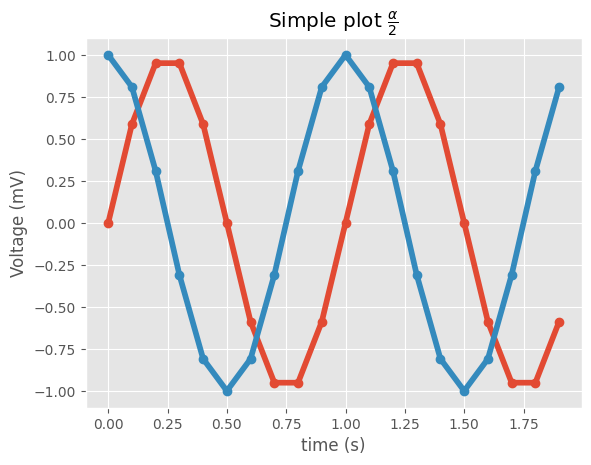

In [15]:
# conda install -c conda-forge tikzplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")

t = np.arange(0.0, 2.0, 0.1)
s = np.sin(2 * np.pi * t)
s2 = np.cos(2 * np.pi * t)
plt.plot(t, s, "o-", lw=4.1)
plt.plot(t, s2, "o-", lw=4.1)
plt.xlabel("time (s)")
plt.ylabel("Voltage (mV)")
plt.title("Simple plot $\\frac{\\alpha}{2}$")
plt.grid(True)

import tikzplotlib

tikzplotlib.save("test.tex")

Arthur: ???? :)


In [16]:
# Create the dynamic system state
n = 30
X = np.array([0]*n)
Y = np.array([0]*n)
N = np.array([0]*n)

system = pd.DataFrame()
system['X'] = X
system['Y'] = Y
system['N'] = N


il sort d'où le 30?

In [17]:
def system_update(system,x,y,b):
    dict = {'X': x, 'Y': y, 'N': b}
    system = system.append(dict, ignore_index = True).drop(index=[0]).reset_index(drop=True)
    return system

def privacy(system):
    n = system['N'].sum()
    if n == 0:
        barx = 0
        bary = 0
        priv = 0
    else:
        barx = np.dot(system['X'], system['N'])/n
        bary = np.dot(system['Y'], system['N'])/n
        #priv = np.sqrt(np.dot((system['X'] - barx)**2 + (system['Y'] - bary)**2, system['N'])/n) 
        priv = np.dot(np.sqrt((system['X'] - barx)**2 + (system['Y'] - bary)**2), system['N'])/n 
    return barx, bary, priv

def utility(x,y):
    return np.sqrt(x**2 + y**2)

def reset_system(system):
    n = len(system)
    X = np.array([0]*n)
    Y = np.array([0]*n)
    N = np.array([0]*n)

    system['X'] = X
    system['Y'] = Y
    system['N'] = N
    return system



Arthur:
barx, bary -> pourquoi on pondère? + c'est censé représenter quoi si c'est juste les coordonnées de x quand elles ont été transmises et 0 sinon? Quelle valeur est censée avoir system[X] quand la donnée n'a pas été transmise (du coup j'imagine que ce serait différent de 0, sinon on aurait jute system[X]= barx)
priv est censé donner quelle information? parce que system[X] - barx du coup ça donne les coordonnées de X quand elles ont pas été transmises et 0 si elles l'ont été, puis ensuite on calcule une moyenne (en divisant par n qui ici est le nombre de fois que les données ont été transmises, donc à priori diff du nombre de fois où elles ont pas été transmises), pas sûr de comprendre à quoi ça sert

Globalement rien compris à ce bout de code :)

Utility -> En fait après on l'a fait via delta_x, delta_y donc on calcule effectivement l'utilité

barx, bary c'est le barycentre en fait :) :) :) , np.dot pour deux vecteurs ça fait le produit scalaire :)

## Random obfuscation protocol

Generate random obfuscation signal and positions

In [18]:
def GeoI_LPPM(x,y,epsilon):
    theta_GeoI = random.uniform(0,2*math.pi)
    r_GeoI = -1/epsilon*(np.real(lambertw((random.random()-1)/math.exp(1),k=-1))+1)
    x_ctrl = x + r_GeoI*math.cos(theta_GeoI)
    y_ctrl = y + r_GeoI*math.sin(theta_GeoI)
    return x_ctrl, y_ctrl, r_GeoI 


Arthur: ça c'est juste Geo-I

In [19]:
#delta = np.random.normal(loc=0.0, scale=350, size=(2,nt))
#x_obf = xs + delta[0,]
#y_obf = ys + delta[1,]
x_obf=np.zeros_like(xs)
y_obf=np.zeros_like(ys)
for i in range(nt):
    x_obf[i] ,y_obf[i], r =GeoI_LPPM(xs[i],ys[i],0.005)
    
delta=np.zeros((2,nt))
delta[0,]=x_obf-xs
delta[1,]=y_obf-ys



Arthur: Du coup quand les données n'ont pas été transmises, xs = ys = 0, et x_obf, y_obf prennent juste les valeurs des bruits?

Simulate real and obfuscated trajectories and transmissions

In [20]:
system = reset_system(system)
barxk = []
baryk = []
privk = []
system_obf = reset_system(system)
barxk_obf = []
baryk_obf = []
privk_obf = []

util = []
for i in range(0,nt,1):
    bi = bs[i] 
    # Update the real system
    system = system_update(system,xs[i],ys[i],bi)
    barx, bary, priv = privacy(system)
    barxk += [barx] 
    baryk += [bary] 
    privk += [priv] 
    # Update the obfuscated system
    system_obf = system_update(system_obf,x_obf[i],y_obf[i],bi)
    barx_obf, bary_obf, priv_obf = privacy(system_obf)
    barxk_obf += [barx_obf] 
    baryk_obf += [bary_obf] 
    privk_obf += [priv_obf] 
    # Compute utility
    util += [utility(delta[0,i],delta[1,i])*bi]

Data_real = pd.DataFrame()
Data_real['x'] = xs
Data_real['y'] = ys
Data_real['b'] = bs
Data_real['barx'] = barxk
Data_real['bary'] = baryk
Data_real['priv'] = privk
Data_real['u_enu'] = us

Data_obf = pd.DataFrame()
Data_obf['x'] = x_obf
Data_obf['y'] = y_obf
Data_obf['U'] = delta[0,]
Data_obf['V'] = delta[1,]
Data_obf['barx'] = barxk_obf
Data_obf['bary'] = baryk_obf
Data_obf['priv'] = privk_obf
Data_obf['util'] = util
Data_obf['u_enu'] = us

pickle.dump( Data_real, open( sol_file+"/Data_real.pkl", "wb" ) )
pickle.dump( Data_obf, open( sol_file+"/Data_obf.pkl", "wb" ) )
    

C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\1699058352.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  system = system.append(dict, ignore_index = True).drop(index=[0]).reset_index(drop=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\1699058352.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  system = system.append(dict, ignore_index = True).drop(index=[0]).reset_index(drop=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\1699058352.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  system = system.append(dict, ignore_index = True).drop(index=[0]).reset_index(drop=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\1699058352.py:3: FutureWarning: The frame.append method is deprecated and wil

In [21]:
fig = figure(min_width=900, min_height=450)
fig.line(xsp, ysp, line_color='navy', legend_label="p")
fig.circle(np.multiply(xs,bs), np.multiply(ys,bs), color='navy', legend_label="p")
fig.circle(np.multiply(x_obf,bs), np.multiply(y_obf,bs), color='orange', legend_label="p obf")
fig.line(barxk, baryk, line_color='navy', legend_label="centr", alpha=0.2)
fig.circle(barxk, baryk, color='navy', legend_label="centr", fill_alpha=0.2, alpha=0.2)
fig.line(barxk_obf, baryk_obf, line_color='orange', legend_label="centr obf", alpha=0.2)
fig.circle(barxk_obf, baryk_obf, color='orange', legend_label="centr obf", fill_alpha=0.2, alpha=0.2)
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "y"
show(fig)

fig = figure(min_width=900, min_height=250)
fig.line(Time, privk, line_color='navy', legend_label="p")
fig.circle(Time, privk, color='navy', legend_label="p obf")
fig.line(Time, privk_obf, line_color='orange', legend_label="p obf")
fig.circle(Time, privk_obf, color='orange', legend_label="p obf")
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "privacy"
show(fig)

fig = figure(min_width=900, min_height=250)
fig.line(Time, np.log10(privk), line_color='navy', legend_label="p")
fig.circle(Time, np.log10(privk), color='navy', legend_label="p obf")
fig.line(Time, np.log10(privk_obf), line_color='orange', legend_label="p obf")
fig.circle(Time, np.log10(privk_obf), color='orange', legend_label="p obf")
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "privacy (log10)"
show(fig)

fig = figure(min_width=900, min_height=250)
# fig.line(Time, util, line_color='navy', legend_label="u")
# fig.circle(Time, np.log10(util), color='navy', legend_label="u")
fig.circle(Time, util, color='navy', legend_label="u")
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "utility loss (log10)"
show(fig)


C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\3435041721.py:24: RuntimeWarning: divide by zero encountered in log10
  fig.line(Time, np.log10(privk), line_color='navy', legend_label="p")
C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\3435041721.py:25: RuntimeWarning: divide by zero encountered in log10
  fig.circle(Time, np.log10(privk), color='navy', legend_label="p obf")
C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\3435041721.py:26: RuntimeWarning: divide by zero encountered in log10
  fig.line(Time, np.log10(privk_obf), line_color='orange', legend_label="p obf")
C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\3435041721.py:27: RuntimeWarning: divide by zero encountered in log10
  fig.circle(Time, np.log10(privk_obf), color='orange', legend_label="p obf")


## Model predictive control

In [22]:
from sys import path
#path.append(r"/localdata/fiacchim/casadi-linux-py36-v3.4.5-64bit")
from casadi import *
from pylab import *

nbuf = n
# Control
u = MX.sym("u")
v = MX.sym("v")
b = MX.sym("b")

# State
x = MX.sym("x",nbuf)
y = MX.sym("y",nbuf)
nx = MX.sym("nx",nbuf)

# Matrices
A = np.zeros((nbuf, nbuf))
B = np.zeros((nbuf, 1))
for i in range(nbuf-1):
    A[i,i+1] = 1

B[nbuf-1,0] = 1
A.tolist()
B.tolist()
A = DM(A)
B = DM(B)

# Dynamics
xplus = A@x + B@u
yplus = A@y + B@v
nplus = A@nx + B@b

# Discrete time dynamics function
F = Function('F', [x,u],[xplus])

#Privacity function
O = DM(np.ones((1,nbuf)))
xbar = (O@(x*nx))/((O@nx)+1e-8)
ybar = O@(y*nx)/((O@nx)+1e-8)
P = (O@( sqrt((x-xbar)**2 + (y-ybar)**2)*nx) )/((O@nx)+1e-8)
J = Function('J', [x,y,nx],[xbar, ybar, P],['x','y','nx'],['xbar', 'ybar','P'])

# Test privacy functions
x1 = np.random.normal(loc=0.0, scale=0.35, size=(1,nbuf)).tolist()[0]
y1 = np.random.normal(loc=0.0, scale=0.35, size=(1,nbuf)).tolist()[0]
nx1 = [1]*nbuf

Jk = J(x=x1,y=y1,nx=nx1)
print(Jk)

df = pd.DataFrame()
df['X'] = x1
df['Y'] = y1
df['N'] = nx1

privacy(df)

{'P': DM(0.444111), 'xbar': DM(0.0959729), 'ybar': DM(0.0836593)}


(0.09597287713076291, 0.0836592982653353, 0.44411070513305806)

Arthur -> pas tout compris là chef


O @nx -> c'est genre somme des éléments de nx? on pouvait juste faire np.sum?


DM c'est quoi?


In [23]:
time.time()

1686051838.7665758

In [24]:
def solve_mpc(xs,ys,bs,horizon,nbuf,util_bound):
    nt = len(xs) #c'est plus le même nt là du coup
    x_mpc = []
    y_mpc = []
    U_mpc = []
    V_mpc = []
    barx_mpc = []
    bary_mpc = []
    priv_mpc = []
    util_mpc = []
    time_mpc = []
    X0 = np.array([0]*nbuf).tolist()
    Y0 = np.array([0]*nbuf).tolist()
    N0 = np.array([0]*nbuf).tolist()

    system_opt = pd.DataFrame()
    system_opt['X'] = X0
    system_opt['Y'] = Y0
    system_opt['N'] = N0

    for tk in range(0,nt-horizon):#nt-horizon):

        if bs[tk] == 0:
            U_mpc += [0]
            V_mpc += [0]
            x_mpc += [xs[tk]]
            y_mpc += [ys[tk]]
            system_opt = system_update(system_opt, xs[tk], ys[tk], 0)
            barxt, baryt, privt = privacy(system_opt)
            barx_mpc += [barxt] 
            bary_mpc += [baryt] 
            priv_mpc += [privt] 
            # Compute utility
            util_mpc += [0]
            time_mpc += [0]
            #system_opt = system_update(system_opt, xs[tk], ys[tk], 0)

        else:
            time_0= time.time()
            X0 = system_opt['X'].tolist()
            Y0 = system_opt['Y'].tolist()
            N0 = system_opt['N'].tolist()

            # Initial conditions
            Jk = 0
            w=[]
            w0 = []
            lbw = []
            ubw = []
            g=[]
            lbg = []
            ubg = []

            # Constraints on input
            U = MX.sym("U",1)
            V = MX.sym("V",1)
            w += [U, V]
            lbw += [-inf]*2
            ubw += [inf]*2
            w0 += [0]*2
            g   += [U**2 + V**2]
            lbg += [0]
            ubg += [util_bound[tk]**2]

            # Initial conditions
            Xk = MX.sym("Xk",nbuf)
            w += [Xk]
            lbw += X0
            ubw += X0
            w0 += X0
            Yk = MX.sym("Yk",nbuf)
            w += [Yk]
            lbw += Y0
            ubw += Y0
            w0 += Y0
            Nk = MX.sym("Nk",nbuf)
            w += [Nk]
            lbw += N0
            ubw += N0
            w0 += N0

            # Future values of x, y and n
            Xf = xs[tk:tk+horizon]
            Xf = Xf[::].tolist()
            Xkfut = MX.sym("Xkfut",horizon) 
            w += [Xkfut]
            lbw += Xf
            ubw += Xf
            w0 += Xf
            Yf = ys[tk:tk+horizon]
            Yf = Yf[::].tolist()
            Ykfut = MX.sym("Ykfut",horizon) 
            w += [Ykfut]
            lbw += Yf
            ubw += Yf
            w0 += Yf
            Nf = bs[tk:tk+horizon]
            Nf = Nf[::].tolist()
            Nkfut = MX.sym("Nkfut",horizon) 
            w += [Nkfut]
            lbw += Nf
            ubw += Nf
            w0 += Nf

            # Apply the first input 
            Xk = F(Xk,Xkfut[0]+U)
            Yk = F(Yk,Ykfut[0]+V)
            Nk = F(Nk,1)
            Jt = J(x=Xk,y=Yk,nx=Nk)
            Jk += Jt['P']
            for k in range(horizon-1):
                # New NLP variable for the control
                Uk = MX.sym('U_' + str(k))
                Vk = MX.sym('V_' + str(k))
                w   += [Uk, Vk]
                lbw += [-util_bound[tk+k+1]*Nf[k+1]]*2
                ubw += [util_bound[tk+k+1]*Nf[k+1]]*2
                w0 += [0]*2

                g   += [Uk**2 + Vk**2]
                lbg += [0]
                ubg += [util_bound[tk+k+1]**2]

                Xk = F(Xk,Xkfut[k+1]+Uk)
                Yk = F(Yk,Ykfut[k+1]+Vk)
                Nk = F(Nk,Nkfut[k+1])
                Jt = J(x=Xk,y=Yk,nx=Nk)
                Jk += Jt['P']


            prob = {'f': -Jk, 'x': vertcat(*w), 'g': vertcat(*g)}
            solver = nlpsol('solver', 'ipopt', prob);
            sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
            w_opt = sol['x'].full().flatten()
            J_opt = -sol['f']

            # Plot the solution
            u_opt = w_opt[0]
            v_opt = w_opt[1]
            U_mpc += [u_opt]
            V_mpc += [v_opt]
            x_mpc += [Xf[0] + u_opt]
            y_mpc += [Yf[0] + v_opt]
            system_opt = system_update(system_opt, Xf[0] + u_opt, Yf[0] + v_opt, 1)
            barxt, baryt, privt = privacy(system_opt)
            barx_mpc += [barxt] 
            bary_mpc += [baryt] 
            priv_mpc += [privt] 
            # Compute utility
            util_mpc += [utility(u_opt,v_opt)]
            time_mpc += [time.time()-time_0]
            #system_opt = system_update(system_opt, Xf[0] + u_opt, Yf[0] + v_opt, 1)
   
    clear_output(wait=False)

    data_mpc = pd.DataFrame()
    data_mpc['x'] = x_mpc
    data_mpc['y'] = y_mpc
    data_mpc['u_enu']= us[:len(x_mpc)]
    data_mpc['U'] = U_mpc
    data_mpc['V'] = V_mpc
    data_mpc['barx'] = barx_mpc
    data_mpc['bary'] = bary_mpc
    data_mpc['priv'] = priv_mpc
    data_mpc['util'] = util_mpc
    data_mpc['time'] = time_mpc
    
    return data_mpc#U_mpc, V_mpc, x_mpc, y_mpc, barx_mpc, bary_mpc, priv_mpc, util_mpc 


In [25]:
def solve_mpc_FLAIR(xs,ys,bs,horizon,nbuf,util_bound, epsilon):
    current_FLAIR_model_x, current_FLAIR_model_y = (0,0,0), (0,0,0)
    model_defined_x = False
    model_defined_y = False
    model = 0
    Xf_FLAIR, Tx_FLAIR, X_FLAIR, Ax_FLAIR = [], [], [], [] #Juste là pour vérifier que tout se passe bien
    nt = len(xs) #c'est plus forcément le même nt qu'avant là du coup
    x_mpc = []
    y_mpc = []
    U_mpc = []
    V_mpc = []
    barx_mpc = []
    bary_mpc = []
    priv_mpc = []
    util_mpc = []
    time_mpc = []
    X0 = np.array([0]*nbuf).tolist()
    Y0 = np.array([0]*nbuf).tolist()
    N0 = np.array([0]*nbuf).tolist()

    system_opt = pd.DataFrame()
    system_opt['X'] = X0
    system_opt['Y'] = Y0
    system_opt['N'] = N0

    for tk in range(0,nt-horizon):#nt-horizon):

        if bs[tk] == 0:
            U_mpc += [0]
            V_mpc += [0]
            x_mpc += [xs[tk]]
            y_mpc += [ys[tk]]
            system_opt = system_update(system_opt, xs[tk], ys[tk], 0)
            barxt, baryt, privt = privacy(system_opt)
            barx_mpc += [barxt] 
            bary_mpc += [baryt] 
            priv_mpc += [privt] 
            # Compute utility
            util_mpc += [0]
            time_mpc += [0]
            #system_opt = system_update(system_opt, xs[tk], ys[tk], 0)

        else:
            time_0= time.time()
            X0 = system_opt['X'].tolist()
            Y0 = system_opt['Y'].tolist()
            N0 = system_opt['N'].tolist()

            # Initial conditions
            Jk = 0
            w=[]
            w0 = []
            lbw = []
            ubw = []
            g=[]
            lbg = []
            ubg = []

            # Constraints on input
            U = MX.sym("U",1)
            V = MX.sym("V",1)
            w += [U, V]
            lbw += [-inf]*2
            ubw += [inf]*2
            w0 += [0]*2
            g   += [U**2 + V**2]
            lbg += [0]
            ubg += [util_bound[tk]**2]

            # Initial conditions
            Xk = MX.sym("Xk",nbuf)
            w += [Xk]
            lbw += X0
            ubw += X0
            w0 += X0
            Yk = MX.sym("Yk",nbuf)
            w += [Yk]
            lbw += Y0
            ubw += Y0
            w0 += Y0
            Nk = MX.sym("Nk",nbuf)
            w += [Nk]
            lbw += N0
            ubw += N0
            w0 += N0

            # Future values of x, y and n
            #Arthur -> donc ici qu'on fout les prédictions
            #À noter que pour le premier point on est pas censé avoir de modèle
                    
                    
                

            #Xf = xs[tk:tk+horizon] #mais c'est pas hyper bizarre de faire xs[tk:tk+horizon]? Si horizon=1 on considère pas le prochain sample
            #ça devrait pas plutôt être horizon + 1?
            Xf, model_defined_x, current_FLAIR_model_x = predict_xf(current_FLAIR_model_x, tk, xs, horizon, model_defined_x, epsilon)
            #current_FLAIR_model ça ressemble à ça: A0_x, t0, x0, x1, t1, A_min_x, A_max_x
            if tk!=0:
                Ax_FLAIR.append(current_FLAIR_model_x[0])
                Tx_FLAIR.append(tk*30)
                X_FLAIR.append(current_FLAIR_model_x[3])
            Xf_FLAIR.append(Xf)
            Xf = Xf[::].tolist()
            Xkfut = MX.sym("Xkfut",horizon) 
            w += [Xkfut]
            lbw += Xf
            ubw += Xf
            w0 += Xf
            #à changer
            #Yf = ys[tk:tk+horizon]
            Yf, model_defined_y, current_FLAIR_model_y = predict_xf(current_FLAIR_model_y, tk, ys, horizon, model_defined_y, epsilon)
            Yf = Yf[::].tolist()
            Ykfut = MX.sym("Ykfut",horizon) 
            w += [Ykfut]
            lbw += Yf
            ubw += Yf
            w0 += Yf
            # à changer
            Nf = np.concatenate((np.array([bs[tk]]), np.ones(horizon - 1))) #comme avec la prédiction de FLAIR on a une prédiction
            #continue, on peut très bien considérer que chaque sample prédis est transmis.
            #Nf = bs[tk:tk+horizon]
            Nf = Nf[::].tolist()
            Nkfut = MX.sym("Nkfut",horizon) 
            w += [Nkfut]
            lbw += Nf
            ubw += Nf
            w0 += Nf

            # Apply the first input 
            Xk = F(Xk,Xkfut[0]+U)
            Yk = F(Yk,Ykfut[0]+V)
            Nk = F(Nk,1)
            Jt = J(x=Xk,y=Yk,nx=Nk)
            Jk += Jt['P']
            for k in range(horizon-1):
                # New NLP variable for the control
                Uk = MX.sym('U_' + str(k))
                Vk = MX.sym('V_' + str(k))
                w   += [Uk, Vk]
                lbw += [-util_bound[tk+k+1]*Nf[k+1]]*2
                ubw += [util_bound[tk+k+1]*Nf[k+1]]*2
                w0 += [0]*2

                g   += [Uk**2 + Vk**2]
                lbg += [0]
                ubg += [util_bound[tk+k+1]**2]

                Xk = F(Xk,Xkfut[k+1]+Uk)
                Yk = F(Yk,Ykfut[k+1]+Vk)
                Nk = F(Nk,Nkfut[k+1])
                Jt = J(x=Xk,y=Yk,nx=Nk)
                Jk += Jt['P']


            prob = {'f': -Jk, 'x': vertcat(*w), 'g': vertcat(*g)}
            solver = nlpsol('solver', 'ipopt', prob);
            sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
            w_opt = sol['x'].full().flatten()
            J_opt = -sol['f']

            # Plot the solution
            u_opt = w_opt[0]
            v_opt = w_opt[1]
            U_mpc += [u_opt]
            V_mpc += [v_opt]
            x_mpc += [Xf[0] + u_opt]
            y_mpc += [Yf[0] + v_opt]
            system_opt = system_update(system_opt, Xf[0] + u_opt, Yf[0] + v_opt, 1)
            barxt, baryt, privt = privacy(system_opt)
            barx_mpc += [barxt] 
            bary_mpc += [baryt] 
            priv_mpc += [privt] 
            # Compute utility
            util_mpc += [utility(u_opt,v_opt)]
            time_mpc += [time.time()-time_0]
            #system_opt = system_update(system_opt, Xf[0] + u_opt, Yf[0] + v_opt, 1)
   
    clear_output(wait=False)

    data_mpc = pd.DataFrame()
    data_mpc['x'] = x_mpc
    data_mpc['y'] = y_mpc
    data_mpc['u_enu']= us[:len(x_mpc)]
    data_mpc['U'] = U_mpc
    data_mpc['V'] = V_mpc
    data_mpc['barx'] = barx_mpc
    data_mpc['bary'] = bary_mpc
    data_mpc['priv'] = priv_mpc
    data_mpc['util'] = util_mpc
    data_mpc['time'] = time_mpc
    
    
    #return data_mpc, Ax_FLAIR, Tx_FLAIR, X_FLAIR, Xf_FLAIR
    return data_mpc#U_mpc, V_mpc, x_mpc, y_mpc, barx_mpc, bary_mpc, priv_mpc, util_mpc 


In [26]:
start_time = time.monotonic()
h = 5
data_mpc_test, Ax_test, Tx_test, X_test, Xf_test = solve_mpc_FLAIR(xs,ys,bs,h,nbuf,util, erreur)
end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))
print(data_mpc['time'])
#Arthur: donc là on a un sample et 15 prédictions.

NameError: name 'predict_xf' is not defined

In [ ]:
h = 5
start_time = time.monotonic()
data_mpc_test2, Ax_test2, Tx_test2, X_test2, Xf_test2 = solve_mpc_FLAIR(xs,ys,bs,h,nbuf,util, erreur)
end_time = time.monotonic()

In [ ]:
Tx_test.insert(0,0)
#je regarde juste à quoi ressemblent les prédictions
fig, ax = plt.subplots()

# Plot points
ax.scatter(Tx_test[1:], X_test, color='red', label='Points')

for i in range(len(X_test)):
    x = X_test[i]
    a = Ax_test[i]
    t1 = Tx_test[i]
    t2 = Tx_test[i+1]
    line_x = np.linspace(t1, t2, 20)  
    line_y = a * (line_x - t1) + x  
    ax.plot(line_x, line_y, color='blue', alpha=0.5)

ax.set_xlabel('Time')
ax.set_ylabel('X coordinate')
ax.set_title('Les coordonnées x avec leur mini modèle associé')
ax.legend()

plt.show()


In [ ]:
Xf_test2
#I would like to point each point the following way: The first point of the first array is plotted at time = 0. The other points of this array are plotted 30 sec after the previous one, and in a different color. Then for the next array, the first point is plotted 30 seconds after the first point of the previous array, and the next points are plotted following the same rule as before

In [ ]:
time_delay = 30

# Initialize time variable
timeXf = 0

# Plotting
for points_array in Xf_test:
    # Plot each point with a time delay and different color
    for i, point in enumerate(points_array):
        if i ==0:
            plt.scatter(timeXf, point, color='red')
        else:
            plt.scatter(timeXf + i*30, point, color='blue')

        # Increment the time variable
        timeXf += time_delay

    # Add a time delay before plotting the next array
    timeXf += time_delay

plt.show()


Du coup ici je mets FLAIR directement dans l'algo d'optimisation. Il est utilisé pour pouvoir obtenir les Xf, Yf, càd les valeurs futures. À noter qu'ici on va recalculer les modèles de FLAIR pour rien à chaque fois qu'on change d'horizon, ce seront toujours les mêmes. On pourrait le faire en offline sur la trajectoire entière en conservant les modèles obtenus point par point (car c'est de ça qu'on a besoin). Je le fais pas parce que le coût de FLAIR est complétement anecdotique par rapport au coût de la résolution du problème d'optimisation (et qu'on change pas tant d'horizon que ça, nous on le fait pour 8 valeurs d'horizon différentes); aussi, c'est un peu le but de FLAIR de pas avoir besoin de conserver en mémoire l'évolution de chacun des modèles (ici, je conserve en mémoire que le dernier modèle).

Arthur: horizon = H?

C'est quoi V?

D'ailleurs quand on mettre la prédiction, outre les valeurs de confidentialité, il faudra aussi regarder si l'utilité est préservée. -> j'en sais rien en fait


In [26]:
def prediction(horizon, coef, last_point, time_gap):
    """Returns an array of size horizon for which index i has value = last_point + (time_gap + 30*i)*(coef)

    Args:
        last_point (float): the last transmitted position (either x-wise or y -wise)
        horizon (int)
        coef (float): the linear coefficient of the current model 

    Returns:
        Xf: the array of predicted positions
    """
    #print(coef, time_gap, last_point)
    return(np.array([last_point + (time_gap + 30*i)*(coef) for i in range(horizon)]))

def FLAIR_insert(x0, x1, x, t0, t1, t, A0, A_min, A_max, epsilon):
    """Inserts a new sample (x,t) into the previous model if possible. Creates a new model otherwise.

    Args:
        x0 (_type_): first sample of the last model
        x1 (_type_): last sample of the last model
        x (_type_): sample to be inserted
        t0 (_type_): first time..
        t1 (_type_): _description_
        t (_type_): _description_
        A0 (_type_): linear coef of the current model
        A_min (_type_): _description_
        A_max (_type_): _description_
        S (_type_): stores x
        A (_type_): stores linear coefs
        T (_type_): stores time

    Returns:
        _type_: _description_
    """
    x_delta, t_delta = x -x0, t - t0
    
    A_t = x_delta/(t_delta+1e-8)
    if A_min <= A_t and A_t <= A_max:
        
        A0 = A_t
        A_min = max(A_min, (x_delta-epsilon)/(t_delta + 1e-12))
        A_max = min(A_max, (x_delta+epsilon)/(t_delta + 1e-12))
    else: 
        t0 = t
        x0, t0 = x1, t1
        x_delta, t_delta = x -x0, t -t0
        A0 = x_delta/(t_delta+1e-12)
        A_min = (x_delta-epsilon)/(t_delta + 1e-12)
        A_max = (x_delta+epsilon)/(t_delta + 1e-12)
    x1, t1 = x, t 
    return (x0, t0, x1, t1, A0, A_min, A_max)





def predict_xf(current_FLAIR_model, tk, xs, horizon, model_defined, epsilon):
    """doc string à ajouter"""
    #je sais c'est crado mais c'est pas si long et loin d'être critique
    if tk == 0: #Pour l'intant tk=0, on a pas encore accès à un modèle FLAIR. Pour l'instant je considère que les prédictions
     #pour tk = 0, ça va être qu'on reste au même endroit à tout instant.
        x0 = xs[tk]#Telle qu'est construite l'harmonisation, on a pas de soucis de valeur non transmise à l'instant 0
        #donc pas besoin de vérifier si bs != 0
        t0 = tk
        #array de taille horizon, rempli de la valeur xs[0]

        A0_x = 0
        return(prediction(horizon, A0_x, x0, tk), model_defined, (A0_x, t0, x0))
    elif (not model_defined):
        if bs[tk] == 0:
            return(prediction(horizon, current_FLAIR_model[0], current_FLAIR_model[2], ts* tk - current_FLAIR_model[1]), model_defined, current_FLAIR_model)
        else:
            x0, t0 = current_FLAIR_model[2],current_FLAIR_model[1]
            model_defined = True
            x1 = xs[tk]
            t1 = ts*tk
            A0_x = (x1-x0)/(t1-t0 +1e-12)
            A_min_x = (x1-epsilon-x0)/(t1-t0 +1e-12)
            A_max_x = (x1+epsilon-x0)/(t1-t0 +1e-12)
            return(prediction(horizon, A0_x, current_FLAIR_model[2], ts*tk - current_FLAIR_model[1]), model_defined, (A0_x, t0, x0, x1, t1, A_min_x, A_max_x))
    else: #on a un modèle, on veut maintenant pouvoir le modifier/ changer de modèle 
        if bs[tk] == 0: #si aucun nouveau sample nous est fournis, on continue avec le dernier modèle en notre possession
            return(prediction(horizon, current_FLAIR_model[0], current_FLAIR_model[2], ts*tk - current_FLAIR_model[1]), model_defined, current_FLAIR_model)
        else:
            x0, t0 = current_FLAIR_model[2],current_FLAIR_model[1]
            x1, t1 = current_FLAIR_model[3],current_FLAIR_model[4]
            print(t0, t1)
            A0_x, A_min_x, A_max_x = current_FLAIR_model[0], current_FLAIR_model[5], current_FLAIR_model[6]
            x0, t0, x1, t1, A0_x, A_min_x, A_max_x = FLAIR_insert(x0, x1, xs[tk], t0, t1, ts*tk, A0_x, A_min_x, A_max_x, epsilon)
            #print('\n coef directeur: ')
            return(prediction(horizon, A0_x, x0, ts*tk - t0), model_defined, (A0_x, t0, x0, x1, t1, A_min_x, A_max_x)) 

In [31]:
start_time = time.monotonic()
h = 15
data_mpc = solve_mpc_FLAIR(xs[:h+1],ys,bs,h,nbuf,util, erreur)
end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))
print(data_mpc['time'])
#Arthur: donc là on a un sample et 15 prédictions.

0:00:00.718000
0    0.659191
Name: time, dtype: float64


In [32]:
start_time = time.monotonic()
h = 15
data_mpc = solve_mpc(xs[:h+1],ys,bs,h,nbuf,util)
end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))
print(data_mpc['time'])
#Arthur: donc là on a un sample et 15 prédictions.

0:00:00.516000
0    0.470117
Name: time, dtype: float64


In [27]:
def xs_pred(data_timed, xs, horizon, X_FLAIR, A_FLAIR, T_FLAIR, Time):
    """Returns xs except the last H = horizon samples are predicted using FLAIR, we then normalise the predictions so that we have
    one sample every 30 seconds. (Also used for ys)
    -> bon bah du coup ça sert à rien :)

    Args:
        xs (array): the initial array
        horizon (int)
        X_FLAIR, A_FLAIR, T_FLAIR (arrays): from the FLAIR model
        Time (array): The array of time samples, after homogenization 

    Returns:
        xs_FLAIR: The new array including the predictions.
    """
    xs_FLAIR = xs.copy()
    #First we look for time_horizon, i.e the time at which we start the predictions
    time_horizon = Time[-horizon]
    #Then we look for the last model of FLAIR, which do not use 
    model = which_model(data_timed, time_horizon, horizon, A_FLAIR, T_FLAIR, X_FLAIR)
    for h in range(horizon):
        xs_FLAIR[-horizon + h] = (time_horizon + h*30 - T_FLAIR[model])*A_FLAIR[model] + X_FLAIR[model]
        #donc là choix à faire, pour l'instant je vais juste partir du dernier modèle avec le point associé au modèle
    return(xs_FLAIR)
    
    


In [28]:
def bs_pred(H, bs):
    """Returns bs except the last H samples are always equal to 1 (we consider that the signal is always transmitted since
    FLAIR's prediction is just a line)
    Args:
        H (int): the horizon
    """
    bs_copy = bs.copy()
    for i in range (1,H+1):
        bs_copy[-i] = 1
    return(bs_copy)


In [37]:
#Avec prédiction

start_time = time.monotonic()
horizons = [5] 
Data_MPC = {} # Empty dictionary
for h in horizons:
    #data_mpc = solve_mpc(xs,ys,bs,h,nbuf,util)
    #solve_mpc_FLAIR(xs,ys,bs,horizon,nbuf,util_bound, epsilon):
    data_mpc = solve_mpc(xs, ys, bs, h, nbuf, util)#solve_mpc_FLAIR(xs, ys, bs, h, nbuf, util, erreur)
    Data_MPC[h] = data_mpc
    end_time = time.monotonic()
    print(h,timedelta(seconds=end_time - start_time))


end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))

#En terme de temps, on est sur du 30 sec pour FLAIR et 29 sec sans

5 0:00:29.015000
0:00:29.015000


In [ ]:
start_time = time.monotonic()
horizons = [5] 
Data_MPC = {} # Empty dictionary
for h in horizons:
    #data_mpc = solve_mpc(xs,ys,bs,h,nbuf,util)
    #solve_mpc_FLAIR(xs,ys,bs,horizon,nbuf,util_bound, epsilon):
    data_mpc = solve_mpc_FLAIR(xs, ys, bs, h, nbuf, util, erreur)
    Data_MPC[h] = data_mpc
    end_time = time.monotonic()
    print(h,timedelta(seconds=end_time - start_time))


end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))

In [29]:
def which_model(data_timed, time_horizon, horizon, A, T, S):
    """Returns the last model (i.e sample and linear coefficient) before the sample of index nbr_samples - nbr_predictions

    Args:
        time_horizon (int): the time at which we start the predictions
        horizon (int): the horizon
        A (array): Linear coefficients
        T (array): Time array 
        S (array): X_FLAIR

    Returns:
        i (int): index corresponding to the last model before time_horizon (this model )
    """
    #Ici, je vais chercher l'indice du dernier sample brut avant time_horizon (donc qui vient de data, avant homogénéisation)
    #(En partant de la fin)
    index_last = -1
    while data_timed['elapsedtime'][index_last] >= time_horizon:
            index_last += -1  
    time_last = data_timed['elapsedtime'][index_last]
    
    #L'idée c'est que le dernier modèle ne doit pas s'appuyer sur un point qui est après time_horizon. Donc il faut s'assurer
    # qu'il y ait au moins un autre point entre le temps associé au dernier modèle et time_horizon.
                 
    for i in range(1, min(len(T),horizon+1)): #ici on essaye de trouver à quel modèle correspond le sample d'indice last_index - nbr_predictions
        #on parcourt la liste T depuis la fin 
        
        if T[-i] < time_last and T[-i] <time_last and abs(T[-i]-time_last) >= 0.001: #je rajoute le abs(T[-i]-time_last) >= 0.001 pour éviter
            #les cas où T[-i] et time_last ont une valeur un tout petit peu différente alors que ça devrait être strictement égal. Déjà eu ça par le passé
            return(-i) 
        # :)
    return(0)

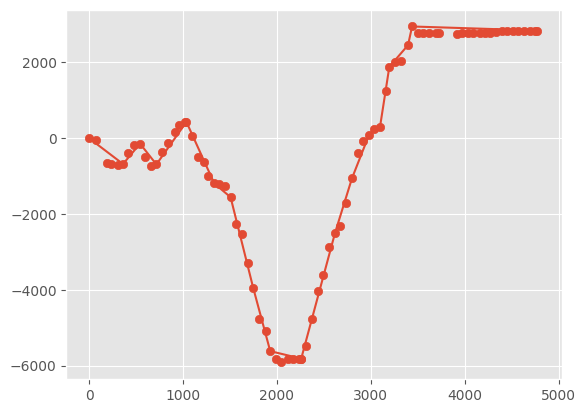

In [30]:
Tx_FLAIR.append(Time[-1])
X_FLAIR.append(data_timed['x'][-1])

plt.scatter(np.array(data_timed['elapsedtime']), np.array(data_timed['x']))
plt.plot(Tx_FLAIR, X_FLAIR)

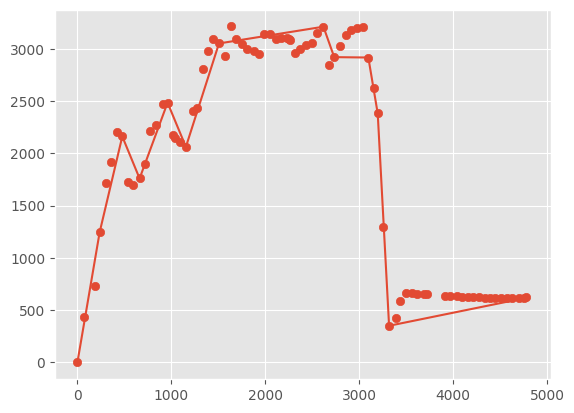

In [31]:
Ty_FLAIR.append(Time[-1])
Y_FLAIR.append(data_timed['y'][-1])

plt.scatter(np.array(data_timed['elapsedtime']), np.array(data_timed['y']))
plt.plot(Ty_FLAIR, Y_FLAIR)
plt.savefig('images/longitude.jpg', format='jpg')

## Essais pdf

In [75]:
from reportlab.pdfgen import canvas

traj_name = "000"
horizon = 2
pdf_name = 'epsilon' + str(erreur) + 'traj' + traj_name + 'horizon' +str(horizon)
pdf_file = pdf_name +".pdf"
c = canvas.Canvas("pdf/"+pdf_file)


x = 0  
y = 0  
width = 200  
height = 150  

image_path = "images/longitude.jpg"
c.drawImage(image_path, x, y, width, height)

c.save()

In [ ]:
def create_pdf(trajectory, epsilon, horizon)

In [32]:
#import
from fpdf import FPDF

#variables
pdf_w=210
pdf_h=297

In [35]:
class PDF(FPDF):
     pass # nothing happens when it is executed.
pdf = PDF()
pdf.add_page()

In [36]:
# PDF metadata

subject = 'parameters : epsilon - ' + str(erreur) + '; trajectory: ' + traj_name + 'horizon: ' +str(horizon) +'; utility bound:'
pdf.set_title("mpc FLAIR results")
pdf.set_author("Arthur le giga boss")
pdf.set_subject(subject)

In [53]:
### define a method
def charts(self, image_name):
        self.set_xy(40.0,25.0)
        self.image(image_name,  link='', type='jpg', w=700/5, h=450/5)
charts(pdf,'images/longitude.jpg')

In [57]:
pdf.image('images/longitude.jpg',  link='', type='jpg', w=700/5, h=450/5)

In [58]:
pdf.output('test2.pdf','F')

''

In [41]:
#Sans prédiction
start_time = time.monotonic()
horizons = [1, 2, 5, 10, 15, 20, 25, 30] 
Data_MPC = {} # Empty dictionary
for h in horizons:
    data_mpc = solve_mpc(xs,ys,bs,h,nbuf,util)
    Data_MPC[h] = data_mpc
    end_time = time.monotonic()
    print(h,timedelta(seconds=end_time - start_time))


end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))
#35 min sans FLAIR


30 0:18:50.859000
0:18:50.859000


In [38]:
#Avec prédiction

start_time_FLAIR = time.monotonic()
horizons = [1, 2, 5, 10, 15, 20, 25, 30] 
Data_MPC_FLAIR = {} # Empty dictionary
for h in horizons:
    data_mpc_FLAIR = solve_mpc_FLAIR(xs,ys,bs,h,nbuf,util,erreur)
    Data_MPC_FLAIR[h] = data_mpc_FLAIR
    end_time = time.monotonic()
    print(h,timedelta(seconds=end_time - start_time))


end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))
#Avec FLAIR, on passe sur du 29 min (? pas trop la réf mais bon. Peut-être le fait que ce soit linéaire facilite le pb d'optimisation)


30 0:29:41.296000
0:29:41.296000


In [42]:
#solution time statics
for h in horizons:
    tiempos=Data_MPC[h]['time']
    print('Horizon ',h)
    print(tiempos.loc[tiempos>0].describe())

Horizon  1
count    78.000000
mean      0.082861
std       0.019419
min       0.054385
25%       0.070534
50%       0.078024
75%       0.089773
max       0.173045
Name: time, dtype: float64
Horizon  2
count    77.000000
mean      0.135980
std       0.030343
min       0.071667
25%       0.107038
50%       0.131421
75%       0.157037
max       0.212061
Name: time, dtype: float64
Horizon  5
count    76.000000
mean      0.404321
std       0.107385
min       0.132018
25%       0.353907
50%       0.382766
75%       0.441484
max       0.910387
Name: time, dtype: float64
Horizon  10
count    73.000000
mean      0.980938
std       0.367467
min       0.272049
25%       0.747223
50%       0.895119
75%       1.086737
max       1.954164
Name: time, dtype: float64
Horizon  15
count    71.000000
mean      1.663647
std       1.373061
min       0.473032
25%       0.925298
50%       1.170316
75%       1.784961
max       9.152807
Name: time, dtype: float64
Horizon  20
count    68.000000
mean      2.52249

In [43]:
# Save data MPC
pickle.dump( horizons, open( sol_file+"/Horizons_MPC.pkl", "wb" ) )
pickle.dump( Data_MPC, open( sol_file+"/Data_MPC.pkl", "wb" ) )


## Evaluate the obfuscation algorithms

In [32]:
# Load data MPC
horizons = pickle.load( open( sol_file+"/Horizons_MPC.pkl", "rb" ) )
Data_MPC = pickle.load( open( sol_file+"/Data_MPC.pkl", "rb" ) )


In [33]:
# Privacy evaluation
ntemp = len(xs)
for h in horizons:
    ntemp = np.min([ntemp,len(np.array(Data_MPC[h].x))])

p_raw = np.array(privk[0:ntemp]).mean()
p_obf = np.array(privk_obf[0:ntemp]).mean()
print("Privacy raw: ", p_raw)
print("Privacy Gauss: ", p_obf, "  ", (p_obf-p_raw)/p_raw)

P_mpc = []
Pper_mpc = []
for h in horizons:
    p_mpc = np.array(Data_MPC[h].priv)[0:ntemp].mean()
    print("Privacy MPC: h = " + str(h) + "  ", p_mpc, "  ", (p_mpc-p_raw)/p_raw)
    P_mpc += [p_mpc]
    Pper_mpc += [(p_mpc-p_raw)/p_raw]

util_mpc = Data_MPC[h].util
Util_mpc = pd.DataFrame(util_mpc)
Util_mpc[Util_mpc > 0].describe()


Privacy raw:  1094.4385994781526
Privacy Gauss:  1150.6745406439325    0.05138336786786774
Privacy MPC: h = 1   1289.564064110674    0.17828817872977132
Privacy MPC: h = 2   1290.9516027533618    0.17955598730610386
Privacy MPC: h = 5   1296.886930358471    0.1849791582431846
Privacy MPC: h = 10   1310.7655918599698    0.19766023647645994
Privacy MPC: h = 15   1322.4410073980803    0.2083281858193262
Privacy MPC: h = 20   1334.5998401848958    0.21943783856057006
Privacy MPC: h = 25   1344.9314194408466    0.22887791063119794
Privacy MPC: h = 30   1345.3470413220334    0.22925766869289732


,util
count,62.000000
mean,366.508042
std,277.787028
min,22.615658
25%,166.800486
50%,303.565939
75%,492.937105
max,1628.374857


In [34]:
from bokeh.plotting import figure, show, output_notebook, output_file, reset_output, save
from bokeh.layouts import gridplot, row, column
from bokeh.models import Range1d
from bokeh.io import output_file, export
from numpy import random
output_notebook()

Colors = []
fig = figure(min_width=900, min_height=450)
fig.line(xsp, ysp, line_color='navy', legend_label="p")
fig.circle(np.multiply(xs,bs), np.multiply(ys,bs), color='navy', legend_label="p")
fig.line(barxk, baryk, line_color='navy', legend_label="centr", alpha=0.2)
fig.circle(barxk, baryk, color='navy', legend_label="centr", fill_alpha=0.2, alpha=0.2)
fig.circle(np.multiply(x_obf,bs), np.multiply(y_obf,bs), color='orange', legend_label="p obf")
fig.line(barxk_obf, baryk_obf, line_color='orange', legend_label="centr obf", alpha=0.2)
fig.circle(barxk_obf, baryk_obf, color='orange', legend_label="centr obf", fill_alpha=0.2, alpha=0.2)
for h in horizons:
    x_mpc = Data_MPC[h].x
    y_mpc = Data_MPC[h].y
    barxk_mpc = Data_MPC[h].barx
    baryk_mpc = Data_MPC[h].bary
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    Colors += [color]
    fig.circle(np.multiply(x_mpc,bs[0:len(y_mpc)]), 
           np.multiply(y_mpc,bs[0:len(y_mpc)]), color=color, legend_label="p mpc "+str(h))
    fig.line(barxk_mpc, baryk_mpc, line_color=color, legend_label="centr mpc "+str(h), alpha=0.2)
    fig.circle(barxk_mpc, baryk_mpc, color=color, legend_label="centr mpc "+str(h), fill_alpha=0.2, alpha=0.2)
fig.xaxis.axis_label = "x"
fig.yaxis.axis_label = "y"
show(fig)

fig = figure(min_width=900, min_height=450)
fig.line(Time, privk, line_color='red', legend_label="p")
fig.circle(Time, privk, color='red', legend_label="p")
fig.line(Time, privk_obf, line_color='orange', legend_label="p obf")
fig.circle(Time, privk_obf, color='orange', legend_label="p obf")
i = 0
for h in horizons:
    priv_mpc = Data_MPC[h].priv
    fig.line(Time[0:len(priv_mpc)], priv_mpc, line_color=Colors[i], legend_label="p mpc "+str(h))
    fig.circle(Time[0:len(priv_mpc)], priv_mpc[0:len(priv_mpc)], color=Colors[i], legend_label="p mpc "+str(h))
    i += 1
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "privacy"
show(fig)

fig = figure(min_width=900, min_height=450)
fig.line(Time, np.log10(privk), line_color='red', legend_label="p")
fig.circle(Time, np.log10(privk), color='red', legend_label="p")
fig.line(Time, np.log10(privk_obf), line_color='orange', legend_label="p obf")
fig.circle(Time, np.log10(privk_obf), color='orange', legend_label="p obf")
i = 0
for h in horizons:
    priv_mpc = Data_MPC[h].priv
    fig.line(Time[0:len(priv_mpc)], np.log10(priv_mpc), line_color=Colors[i], legend_label="p mpc "+str(h))
    fig.circle(Time[0:len(priv_mpc)], np.log10(priv_mpc[0:len(priv_mpc)]), color=Colors[i], legend_label="p mpc "+str(h))
    i += 1
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "privacy"
output_file("images/plot_priv.html")

# Save the plot as a JPG file
export.export_png(fig, filename="images/plot_priv.png")
show(fig)


fig = figure(min_width=900, min_height=250)
# fig.line(Time, util, line_color='orange', legend_label="util obf")
fig.circle(Time, np.log10(util), color='orange', legend_label="util obf")
i = 0
for h in horizons[:2]:
    util_mpc = Data_MPC[h].util
#     fig.line(Time[0:len(util_mpc)], util_mpc, line_color=Colors[i], legend_label="util mpc "+str(h))
    fig.circle(Time[0:len(util_mpc)], np.log10(util_mpc[0:len(util_mpc)]), color=Colors[i], legend_label="util mpc "+str(h))
    i += 1
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "utility loss"
show(fig)



Loading BokehJS ...

C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\652724112.py:49: RuntimeWarning: divide by zero encountered in log10
  fig.line(Time, np.log10(privk), line_color='red', legend_label="p")
C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\652724112.py:50: RuntimeWarning: divide by zero encountered in log10
  fig.circle(Time, np.log10(privk), color='red', legend_label="p")
C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\652724112.py:51: RuntimeWarning: divide by zero encountered in log10
  fig.line(Time, np.log10(privk_obf), line_color='orange', legend_label="p obf")
C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\652724112.py:52: RuntimeWarning: divide by zero encountered in log10
  fig.circle(Time, np.log10(privk_obf), color='orange', legend_label="p obf")
C:\Users\arthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  resul

C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\652724112.py:71: RuntimeWarning: divide by zero encountered in log10
  fig.circle(Time, np.log10(util), color='orange', legend_label="util obf")
C:\Users\arthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [35]:
fig = figure(plot_width=900, plot_height=450)
fig.line(np.array([0]+horizons), [(p_obf-p_raw)/p_raw]+Pper_mpc, line_color='navy', legend_label="privacy gain %")
fig.circle(np.array([0]+horizons), [(p_obf-p_raw)/p_raw]+Pper_mpc, line_color='navy', legend_label="privacy gain %")
fig.xaxis.axis_label = "horizon"
fig.yaxis.axis_label = "privacy improvement"
fig.x_range = Range1d(0, max(horizons))
fig.y_range = Range1d(0, max(Pper_mpc)*1.25)
show(fig)


AttributeError: unexpected attribute 'plot_width' to figure, similar attributes are outer_width, width or min_width

In [36]:
fig = figure(plot_width=900, plot_height=450)
fig.line(np.array(horizons), Pper_mpc, line_color='navy', legend_label="privacy gain %")
fig.circle(np.array(horizons), Pper_mpc, line_color='navy', legend_label="privacy gain %")
fig.line(np.array(horizons), [(p_obf-p_raw)/p_raw]*len(horizons), line_color='red', legend_label="privacy gain gaussian %")
fig.xaxis.axis_label = "horizon"
fig.yaxis.axis_label = "privacy improvement"
fig.x_range = Range1d(1, max(horizons))
fig.y_range = Range1d(0, max(Pper_mpc)*1.25)
show(fig)

AttributeError: unexpected attribute 'plot_width' to figure, similar attributes are outer_width, width or min_width

# Visualisation on a map

Traces will be plotted using [geojson.io](https://geojson.io/) tool, "Open" option in the menu. Data will be exported in csv with the following columns: marker-color,lat,lon Color should be specified using the HEX color code
### Raw trace

In [37]:
l_raw=pd.DataFrame() 
l_raw['lat'], l_raw['lon'] = pymap3d.enu2geodetic(Data_real['x'], Data_real['y'], Data_real['u_enu'], lat0, lon0, h0, ell=ell_grs80)[0:2]
l_raw['marker-color'] = '#000080'
os.makedirs(sol_file+'/visualisation-map', exist_ok=True)
l_raw.to_csv(sol_file+'/visualisation-map/'+dataset+'_'+user+'_raw.csv')

### GeoI trace

### GeoI trace

In [38]:
Data_obf2=Data_obf[Data_obf.util!=0]

In [39]:
#Modify to plot transmitted points
l_geoi=pd.DataFrame() 

l_geoi['lat'], l_geoi['lon'] = pymap3d.enu2geodetic(Data_obf[Data_obf.util!=0]['x'], Data_obf[Data_obf.util!=0]['y'], Data_obf[Data_obf.util!=0]['u_enu'], lat0, lon0, h0, ell=ell_grs80)[0:2]
l_geoi['marker-color'] = '#FF8000'
l_geoi.to_csv(sol_file+'/visualisation-map/'+dataset+'_'+user+'_geoi.csv')

### MPC trace H

In [ ]:
H = 5
l_mpc=pd.DataFrame() 
l_mpc['lat'], l_mpc['lon'] = pymap3d.enu2geodetic(Data_MPC[H]['x'], Data_MPC[H]['y'], Data_MPC[H]['u_enu'], lat0, lon0, h0, ell=ell_grs80)[0:2]
l_mpc['marker-color'] = '#7CFC00'
l_mpc.to_csv(sol_file+'/visualisation-map/'+dataset+'_'+user+'_mpc_'+str(H)+'.csv')

## With FLAIR's prediction

In [43]:
#solution time statics
for h in horizons:
    tiempos=Data_MPC_FLAIR[h]['time']
    print('Horizon ',h)
    print(tiempos.loc[tiempos>0].describe())
    
    
# Save data MPC
pickle.dump( horizons, open( sol_file+"/Horizons_MPC.pkl", "wb" ) ) #aucune raison de changer ça, ça devrait être la mm chose avec 
#ou sans prédiction
pickle.dump( Data_MPC_FLAIR, open( sol_file+"/Data_MPC_FLAIR.pkl", "wb" ) )


# Load data MPC
horizons = pickle.load( open( sol_file+"/Horizons_MPC.pkl", "rb" ) )
Data_MPC_FLAIR = pickle.load( open( sol_file+"/Data_MPC_FLAIR.pkl", "rb" ) )

NameError: name 'Data_MPC_FLAIR' is not defined

In [44]:
# Privacy evaluation
ntemp = len(xs)
for h in horizons:
    ntemp = np.min([ntemp,len(np.array(Data_MPC_FLAIR[h].x))])

p_raw = np.array(privk[0:ntemp]).mean()
p_obf = np.array(privk_obf[0:ntemp]).mean()
print("Privacy raw: ", p_raw)
print("Privacy Gauss: ", p_obf, "  ", (p_obf-p_raw)/p_raw)

P_mpc = []
Pper_mpc = []
for h in horizons:
    p_mpc = np.array(Data_MPC_FLAIR[h].priv)[0:ntemp].mean()
    print("Privacy MPC: h = " + str(h) + "  ", p_mpc, "  ", (p_mpc-p_raw)/p_raw)
    P_mpc += [p_mpc]
    Pper_mpc += [(p_mpc-p_raw)/p_raw]

util_mpc = Data_MPC_FLAIR[h].util
Util_mpc = pd.DataFrame(util_mpc)
Util_mpc[Util_mpc > 0].describe()


NameError: name 'Data_MPC_FLAIR' is not defined

In [45]:
from bokeh.plotting import figure, show, output_notebook, output_file, reset_output, save
from bokeh.layouts import gridplot, row, column
from bokeh.models import Range1d
from numpy import random
output_notebook()

Colors = []
fig = figure(min_width=900, min_height=450)
fig.line(xsp, ysp, line_color='navy', legend_label="p")
fig.circle(np.multiply(xs,bs), np.multiply(ys,bs), color='navy', legend_label="p")
fig.line(barxk, baryk, line_color='navy', legend_label="centr", alpha=0.2)
fig.circle(barxk, baryk, color='navy', legend_label="centr", fill_alpha=0.2, alpha=0.2)
fig.circle(np.multiply(x_obf,bs), np.multiply(y_obf,bs), color='orange', legend_label="p obf")
fig.line(barxk_obf, baryk_obf, line_color='orange', legend_label="centr obf", alpha=0.2)
fig.circle(barxk_obf, baryk_obf, color='orange', legend_label="centr obf", fill_alpha=0.2, alpha=0.2)
for h in horizons:
    x_mpc = Data_MPC_FLAIR[h].x
    y_mpc = Data_MPC_FLAIR[h].y
    barxk_mpc = Data_MPC_FLAIR[h].barx
    baryk_mpc = Data_MPC_FLAIR[h].bary
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) #??? :) 
    Colors += [color]
    fig.circle(np.multiply(x_mpc,bs[0:len(y_mpc)]), 
           np.multiply(y_mpc,bs[0:len(y_mpc)]), color=color, legend_label="p mpc "+str(h))
    fig.line(barxk_mpc, baryk_mpc, line_color=color, legend_label="centr mpc "+str(h), alpha=0.2)
    fig.circle(barxk_mpc, baryk_mpc, color=color, legend_label="centr mpc "+str(h), fill_alpha=0.2, alpha=0.2)
fig.xaxis.axis_label = "x"
fig.yaxis.axis_label = "y"
show(fig)

fig = figure(min_width=900, min_height=450)
fig.line(Time, privk, line_color='red', legend_label="p")
fig.circle(Time, privk, color='red', legend_label="p")
fig.line(Time, privk_obf, line_color='orange', legend_label="p obf")
fig.circle(Time, privk_obf, color='orange', legend_label="p obf")
i = 0
for h in horizons:
    priv_mpc = Data_MPC_FLAIR[h].priv
    fig.line(Time[0:len(priv_mpc)], priv_mpc, line_color=Colors[i], legend_label="p mpc "+str(h))
    fig.circle(Time[0:len(priv_mpc)], priv_mpc[0:len(priv_mpc)], color=Colors[i], legend_label="p mpc "+str(h))
    i += 1
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "privacy"
show(fig)

fig = figure(min_width=900, min_height=450)
fig.line(Time, np.log10(privk), line_color='red', legend_label="p")
fig.circle(Time, np.log10(privk), color='red', legend_label="p")
fig.line(Time, np.log10(privk_obf), line_color='orange', legend_label="p obf")
fig.circle(Time, np.log10(privk_obf), color='orange', legend_label="p obf")
i = 0
for h in horizons:
    priv_mpc = Data_MPC_FLAIR[h].priv
    fig.line(Time[0:len(priv_mpc)], np.log10(priv_mpc), line_color=Colors[i], legend_label="p mpc "+str(h))
    fig.circle(Time[0:len(priv_mpc)], np.log10(priv_mpc[0:len(priv_mpc)]), color=Colors[i], legend_label="p mpc "+str(h))
    i += 1
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "privacy"
show(fig)


fig = figure(min_width=900, min_height=250)
# fig.line(Time, util, line_color='orange', legend_label="util obf")
fig.circle(Time, np.log10(util), color='orange', legend_label="util obf")
i = 0
for h in horizons:
    util_mpc = Data_MPC_FLAIR[h].util
#     fig.line(Time[0:len(util_mpc)], util_mpc, line_color=Colors[i], legend_label="util mpc "+str(h))
    fig.circle(Time[0:len(util_mpc)], np.log10(util_mpc[0:len(util_mpc)]), color=Colors[i], legend_label="util mpc "+str(h))
    i += 1
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "utility loss"
show(fig)

Loading BokehJS ...

NameError: name 'Data_MPC_FLAIR' is not defined

In [50]:
Data_MPC_FLAIR[1]

,x,y,u_enu,U,V,barx,bary,priv,util,time
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.056011
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-63.803901,717.716694,-0.015077,-25.026620,281.519192,-31.901951,358.858347,360.273574,282.629416,0.086025
3,0.000000,0.000000,0.000000,0.000000,0.000000,-31.901951,358.858347,360.273574,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,-31.901951,358.858347,360.273574,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
154,2839.839640,-122.906349,-0.653376,-446.921265,169.463170,3703.586125,-564.210575,791.869618,477.971111,0.088033
155,0.000000,0.000000,0.000000,0.000000,0.000000,3703.586125,-564.210575,791.869618,0.000000,0.000000
156,2981.595555,-108.411107,-0.651778,-295.591391,145.478405,3652.015370,-531.653470,785.106872,329.451418,0.079024
157,0.000000,0.000000,0.000000,0.000000,0.000000,3652.015370,-531.653470,785.106872,0.000000,0.000000


In [54]:
fig = figure(min_width=900, min_height=450)
fig.line(np.array([0]+horizons), [(p_obf-p_raw)/p_raw]+Pper_mpc, line_color='navy', legend_label="privacy gain %")
fig.circle(np.array([0]+horizons), [(p_obf-p_raw)/p_raw]+Pper_mpc, line_color='navy', legend_label="privacy gain %")
fig.xaxis.axis_label = "horizon"
fig.yaxis.axis_label = "privacy improvement"
fig.x_range = Range1d(0, max(horizons))
fig.y_range = Range1d(0, max(Pper_mpc)*1.25)
show(fig)


AttributeError: Figure.set() got an unexpected keyword argument 'min_width'

In [45]:
fig = figure(min_width=900, min_height=450)
fig.line(np.array(horizons), Pper_mpc, line_color='navy', legend_label="privacy gain %")
fig.circle(np.array(horizons), Pper_mpc, line_color='navy', legend_label="privacy gain %")
fig.line(np.array(horizons), [(p_obf-p_raw)/p_raw]*len(horizons), line_color='red', legend_label="privacy gain gaussian %")
fig.xaxis.axis_label = "horizon"
fig.yaxis.axis_label = "privacy improvement"
fig.x_range = Range1d(1, max(horizons))
fig.y_range = Range1d(0, max(Pper_mpc)*1.25)
show(fig)

In [46]:
# Raw trace
l_raw=pd.DataFrame() 
l_raw['lat'], l_raw['lon'] = pymap3d.enu2geodetic(Data_real['x'], Data_real['y'], Data_real['u_enu'], lat0, lon0, h0, ell=ell_grs80)[0:2]
l_raw['marker-color'] = '#000080'
os.makedirs(sol_file+'/visualisation-map', exist_ok=True)
l_raw.to_csv(sol_file+'/visualisation-map/'+dataset+'_'+user+'_raw.csv')

In [47]:
#GEO-I
Data_obf2=Data_obf[Data_obf.util!=0]

#Modify to plot transmitted points
l_geoi=pd.DataFrame() 

l_geoi['lat'], l_geoi['lon'] = pymap3d.enu2geodetic(Data_obf[Data_obf.util!=0]['x'], Data_obf[Data_obf.util!=0]['y'], Data_obf[Data_obf.util!=0]['u_enu'], lat0, lon0, h0, ell=ell_grs80)[0:2]
l_geoi['marker-color'] = '#FF8000'
l_geoi.to_csv(sol_file+'/visualisation-map/'+dataset+'_'+user+'_geoi.csv')

In [48]:
#MPC trace-H (FLAIR)

H = 5
l_mpc=pd.DataFrame() 
l_mpc['lat'], l_mpc['lon'] = pymap3d.enu2geodetic(Data_MPC_FLAIR[H]['x'], Data_MPC_FLAIR[H]['y'], Data_MPC_FLAIR[H]['u_enu'], lat0, lon0, h0, ell=ell_grs80)[0:2]
l_mpc['marker-color'] = '#7CFC00'
l_mpc.to_csv(sol_file+'/visualisation-map/'+dataset+'_'+user+'_mpc_'+str(H)+'.csv')

In [76]:
#Avec prédiction, ça je le fais juste pour la réu

start_time_FLAIR2 = time.monotonic()
horizons = [1, 2, 5, 10, 15, 20, 25, 30] 
Data_MPC_FLAIR2 = {} # Empty dictionary
for h in horizons:
    data_mpc_FLAIR2 = solve_mpc_FLAIR(xs,ys,bs,h,nbuf,util,erreur)
    Data_MPC_FLAIR2[h] = data_mpc_FLAIR2
    end_time = time.monotonic()
    print(h,timedelta(seconds=end_time - start_time_FLAIR2))


# end_time = time.monotonic()
# print(timedelta(seconds=end_time - start_time))
#Avec FLAIR, on passe sur du 29 min (? pas trop la réf mais bon. Peut-être le fait que ce soit linéaire facilite le pb d'optimisation)


30 0:26:25.547000


In [77]:
Data_MPC_FLAIR3 = {} # Empty dictionary
for h in horizons:
    Data_MPC_FLAIR3[h] = Data_MPC_FLAIR2[h][0]

KeyError: 0

In [78]:
#solution time statics
for h in horizons:
    tiempos=Data_MPC_FLAIR2[h]['time']
    print('Horizon ',h)
    print(tiempos.loc[tiempos>0].describe())
    
    
# Save data MPC
pickle.dump( horizons, open( sol_file+"/Horizons_MPC.pkl", "wb" ) ) #aucune raison de changer ça, ça devrait être la mm chose avec 
#ou sans prédiction
pickle.dump( Data_MPC_FLAIR2, open( sol_file+"/Data_MPC_FLAIR2.pkl", "wb" ) )


# Load data MPC
horizons = pickle.load( open( sol_file+"/Horizons_MPC.pkl", "rb" ) )
Data_MPC_FLAIR2 = pickle.load( open( sol_file+"/Data_MPC_FLAIR2.pkl", "rb" ) )

Horizon  1
count    78.000000
mean      0.100234
std       0.100048
min       0.056012
25%       0.076017
50%       0.086518
75%       0.094019
max       0.949774
Name: time, dtype: float64
Horizon  2
count    77.000000
mean      0.170767
std       0.244798
min       0.073018
25%       0.116026
50%       0.146032
75%       0.170042
max       2.273537
Name: time, dtype: float64
Horizon  5
count    76.000000
mean      0.440886
std       0.231414
min       0.133028
25%       0.365832
50%       0.392721
75%       0.429965
max       1.957122
Name: time, dtype: float64
Horizon  10
count    73.000000
mean      1.068086
std       0.593338
min       0.280063
25%       0.754464
50%       0.930472
75%       1.133263
max       3.925554
Name: time, dtype: float64
Horizon  15
count    71.000000
mean      2.243282
std       1.115390
min       0.451095
25%       1.537166
50%       2.012353
75%       2.436447
max       7.525652
Name: time, dtype: float64
Horizon  20
count    68.000000
mean      3.48977

In [79]:
# Load data MPC
horizons = pickle.load( open( sol_file+"/Horizons_MPC.pkl", "rb" ) )
Data_MPC_FLAIR2 = pickle.load( open( sol_file+"/Data_MPC_FLAIR2.pkl", "rb" ) )

In [80]:
from bokeh.plotting import figure, show, output_notebook, output_file, reset_output, save
from bokeh.layouts import gridplot, row, column
from bokeh.models import Range1d
from numpy import random
output_notebook()

Colors = []
fig = figure(min_width=900, min_height=450)
fig.line(xsp, ysp, line_color='navy', legend_label="p")
fig.circle(np.multiply(xs,bs), np.multiply(ys,bs), color='navy', legend_label="p")
fig.line(barxk, baryk, line_color='navy', legend_label="centr", alpha=0.2)
fig.circle(barxk, baryk, color='navy', legend_label="centr", fill_alpha=0.2, alpha=0.2)
fig.circle(np.multiply(x_obf,bs), np.multiply(y_obf,bs), color='orange', legend_label="p obf")
fig.line(barxk_obf, baryk_obf, line_color='orange', legend_label="centr obf", alpha=0.2)
fig.circle(barxk_obf, baryk_obf, color='orange', legend_label="centr obf", fill_alpha=0.2, alpha=0.2)
for h in horizons:
    x_mpc = Data_MPC_FLAIR2[h].x
    y_mpc = Data_MPC_FLAIR2[h].y
    barxk_mpc = Data_MPC_FLAIR2[h].barx
    baryk_mpc = Data_MPC_FLAIR2[h].bary
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) #??? :) 
    Colors += [color]
    fig.circle(np.multiply(x_mpc,bs[0:len(y_mpc)]), 
           np.multiply(y_mpc,bs[0:len(y_mpc)]), color=color, legend_label="p mpc "+str(h))
    fig.line(barxk_mpc, baryk_mpc, line_color=color, legend_label="centr mpc "+str(h), alpha=0.2)
    fig.circle(barxk_mpc, baryk_mpc, color=color, legend_label="centr mpc "+str(h), fill_alpha=0.2, alpha=0.2)
fig.xaxis.axis_label = "x"
fig.yaxis.axis_label = "y"
show(fig)

fig = figure(min_width=900, min_height=450)
fig.line(Time, privk, line_color='red', legend_label="p")
fig.circle(Time, privk, color='red', legend_label="p")
fig.line(Time, privk_obf, line_color='orange', legend_label="p obf")
fig.circle(Time, privk_obf, color='orange', legend_label="p obf")
i = 0
for h in horizons:
    priv_mpc = Data_MPC_FLAIR2[h].priv
    fig.line(Time[0:len(priv_mpc)], priv_mpc, line_color=Colors[i], legend_label="p mpc "+str(h))
    fig.circle(Time[0:len(priv_mpc)], priv_mpc[0:len(priv_mpc)], color=Colors[i], legend_label="p mpc "+str(h))
    i += 1
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "privacy"
show(fig)

fig = figure(min_width=900, min_height=450)
fig.line(Time, np.log10(privk), line_color='red', legend_label="p")
fig.circle(Time, np.log10(privk), color='red', legend_label="p")
fig.line(Time, np.log10(privk_obf), line_color='orange', legend_label="p obf")
fig.circle(Time, np.log10(privk_obf), color='orange', legend_label="p obf")
i = 0
for h in horizons:
    priv_mpc = Data_MPC_FLAIR2[h].priv
    fig.line(Time[0:len(priv_mpc)], np.log10(priv_mpc), line_color=Colors[i], legend_label="p mpc "+str(h))
    fig.circle(Time[0:len(priv_mpc)], np.log10(priv_mpc[0:len(priv_mpc)]), color=Colors[i], legend_label="p mpc "+str(h))
    i += 1
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "privacy"
show(fig)


fig = figure(min_width=900, min_height=250)
# fig.line(Time, util, line_color='orange', legend_label="util obf")
fig.circle(Time, np.log10(util), color='orange', legend_label="util obf")
i = 0
for h in horizons:
    util_mpc = Data_MPC_FLAIR2[h].util
#     fig.line(Time[0:len(util_mpc)], util_mpc, line_color=Colors[i], legend_label="util mpc "+str(h))
    fig.circle(Time[0:len(util_mpc)], np.log10(util_mpc[0:len(util_mpc)]), color=Colors[i], legend_label="util mpc "+str(h))
    i += 1
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "utility loss"
show(fig)

Loading BokehJS ...

C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\4196041058.py:48: RuntimeWarning: divide by zero encountered in log10
  fig.line(Time, np.log10(privk), line_color='red', legend_label="p")
C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\4196041058.py:49: RuntimeWarning: divide by zero encountered in log10
  fig.circle(Time, np.log10(privk), color='red', legend_label="p")
C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\4196041058.py:50: RuntimeWarning: divide by zero encountered in log10
  fig.line(Time, np.log10(privk_obf), line_color='orange', legend_label="p obf")
C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\4196041058.py:51: RuntimeWarning: divide by zero encountered in log10
  fig.circle(Time, np.log10(privk_obf), color='orange', legend_label="p obf")
C:\Users\arthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  r

C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\4196041058.py:66: RuntimeWarning: divide by zero encountered in log10
  fig.circle(Time, np.log10(util), color='orange', legend_label="util obf")


## Analyse résultats 
Comparons les résultats du MPC avec une prédiction made in FLAIR, avec du MPC oracle et du Geo-I

In [81]:
# Load data MPC
horizons = pickle.load( open( sol_file+"/Horizons_MPC.pkl", "rb" ) )
Data_MPC_FLAIR2 = pickle.load( open( sol_file+"/Data_MPC_FLAIR2.pkl", "rb" ) )

horizons = pickle.load( open( sol_file+"/Horizons_MPC.pkl", "rb" ) )
Data_MPC = pickle.load( open( sol_file+"/Data_MPC.pkl", "rb" ) )

In [82]:
l_raw=pd.DataFrame() 
l_raw['lat'], l_raw['lon'] = pymap3d.enu2geodetic(Data_real['x'], Data_real['y'], Data_real['u_enu'], lat0, lon0, h0, ell=ell_grs80)[0:2]
l_raw['marker-color'] = '#000080'
os.makedirs(sol_file+'/visualisation-map', exist_ok=True)
l_raw.to_csv(sol_file+'/visualisation-map/'+dataset+'_'+user+'_raw.csv')

In [83]:
# Privacy evaluation
horizons = [1,5,10,20]
ntemp = len(xs)
for h in horizons:
    ntemp = np.min([ntemp,len(np.array(Data_MPC[h].x))])

p_raw = np.array(privk[0:ntemp]).mean()
p_obf = np.array(privk_obf[0:ntemp]).mean()
print("Privacy raw: ", p_raw)
print("Privacy Gauss: ", p_obf, "  ", (p_obf-p_raw)/p_raw)

P_mpc = []
Pper_mpc = []
for h in horizons:
    p_mpc = np.array(Data_MPC[h].priv)[0:ntemp].mean()
    p_mpc_FLAIR = np.array(Data_MPC_FLAIR2[h].priv)[0:ntemp].mean()
    print("Privacy MPC FLAIR: h = " + str(h) + "  ", p_mpc_FLAIR, "  ", (p_mpc_FLAIR-p_raw)/p_raw)
    print("Privacy MPC: h = " + str(h) + "  ", p_mpc, "  ", (p_mpc-p_raw)/p_raw)
    P_mpc += [p_mpc]
    Pper_mpc += [(p_mpc-p_raw)/p_raw]
    

Privacy raw:  1057.0797667792608
Privacy Gauss:  1117.2471669695876    0.05691850518872996
Privacy MPC FLAIR: h = 1   1201.5487463792565    0.13666800192398695
Privacy MPC: h = 1   1245.6117107786115    0.1783516721484273
Privacy MPC FLAIR: h = 5   1204.9278595232333    0.1398646510796816
Privacy MPC: h = 5   1252.2569613697165    0.1846380951790675
Privacy MPC FLAIR: h = 10   1200.748280237292    0.1359107590298169
Privacy MPC: h = 10   1265.7784084915131    0.19742941665426156
Privacy MPC FLAIR: h = 20   1175.6134370745633    0.11213313698781133
Privacy MPC: h = 20   1292.2329575839726    0.2224554836776253


In [80]:
#Utility oracle
#ici util correspond à la loss donc moins c'est grand mieux c'est
h = 10
util_mpc = Data_MPC[h].util
Util_mpc = pd.DataFrame(util_mpc)
Util_mpc[Util_mpc > 0].describe()

,util
count,72.000000
mean,370.078064
std,291.653137
min,21.424460
25%,159.203535
50%,312.198457
75%,504.964589
max,1628.374857


In [79]:
#Utility FLAIR
h = 10
util_mpc_FLAIR = Data_MPC_FLAIR2[h].util
Util_mpc_FLAIR = pd.DataFrame(util_mpc_FLAIR)
Util_mpc_FLAIR[Util_mpc_FLAIR > 0].describe()

,util
count,72.000000
mean,391.934130
std,238.168797
min,5.845527
25%,202.956378
50%,339.146021
75%,501.695939
max,1074.169936


In [84]:
from bokeh.plotting import figure, show, output_notebook, output_file, reset_output, save
from bokeh.layouts import gridplot, row, column
from bokeh.models import Range1d
from numpy import random
output_notebook()

Colors = []
fig = figure(min_width=900, min_height=450)
fig.line(xsp, ysp, line_color='navy', legend_label="p")
fig.circle(np.multiply(xs,bs), np.multiply(ys,bs), color='navy', legend_label="p")
fig.line(barxk, baryk, line_color='navy', legend_label="centr", alpha=0.2)
fig.circle(barxk, baryk, color='navy', legend_label="centr", fill_alpha=0.2, alpha=0.2)
fig.circle(np.multiply(x_obf,bs), np.multiply(y_obf,bs), color='orange', legend_label="p obf")
fig.line(barxk_obf, baryk_obf, line_color='orange', legend_label="centr obf", alpha=0.2)
fig.circle(barxk_obf, baryk_obf, color='orange', legend_label="centr obf", fill_alpha=0.2, alpha=0.2)
for h in horizons:
    x_mpc = Data_MPC[h].x
    y_mpc = Data_MPC[h].y
    barxk_mpc = Data_MPC[h].barx
    baryk_mpc = Data_MPC[h].bary
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    Colors += [color]
    fig.circle(np.multiply(x_mpc,bs[0:len(y_mpc)]), 
           np.multiply(y_mpc,bs[0:len(y_mpc)]), color=color, legend_label="p mpc "+str(h))
    fig.line(barxk_mpc, baryk_mpc, line_color=color, legend_label="centr mpc "+str(h), alpha=0.2)
    fig.circle(barxk_mpc, baryk_mpc, color=color, legend_label="centr mpc "+str(h), fill_alpha=0.2, alpha=0.2)
fig.xaxis.axis_label = "x"
fig.yaxis.axis_label = "y"
show(fig)

fig = figure(min_width=900, min_height=450)
fig.line(Time, privk, line_color='red', legend_label="p")
fig.circle(Time, privk, color='red', legend_label="p")
fig.line(Time, privk_obf, line_color='orange', legend_label="p obf")
fig.circle(Time, privk_obf, color='orange', legend_label="p obf")
i = 0
for h in horizons:
    priv_mpc = Data_MPC[h].priv
    fig.line(Time[0:len(priv_mpc)], priv_mpc, line_color=Colors[i], legend_label="p mpc "+str(h))
    fig.circle(Time[0:len(priv_mpc)], priv_mpc[0:len(priv_mpc)], color=Colors[i], legend_label="p mpc "+str(h))
    i += 1
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "privacy"
show(fig)

fig = figure(min_width=900, min_height=450)
fig.line(Time, np.log10(privk), line_color='red', legend_label="p")
fig.circle(Time, np.log10(privk), color='red', legend_label="p")
fig.line(Time, np.log10(privk_obf), line_color='orange', legend_label="p obf")
fig.circle(Time, np.log10(privk_obf), color='orange', legend_label="p obf")
i = 0
for h in horizons:
    priv_mpc = Data_MPC[h].priv
    fig.line(Time[0:len(priv_mpc)], np.log10(priv_mpc), line_color=Colors[i], legend_label="p mpc "+str(h))
    fig.circle(Time[0:len(priv_mpc)], np.log10(priv_mpc[0:len(priv_mpc)]), color=Colors[i], legend_label="p mpc "+str(h))
    i += 1
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "privacy"
show(fig)


fig = figure(min_width=900, min_height=250)
# fig.line(Time, util, line_color='orange', legend_label="util obf")
fig.circle(Time, np.log10(util), color='orange', legend_label="util obf")
i = 0
for h in horizons:
    util_mpc = Data_MPC[h].util
#     fig.line(Time[0:len(util_mpc)], util_mpc, line_color=Colors[i], legend_label="util mpc "+str(h))
    fig.circle(Time[0:len(util_mpc)], np.log10(util_mpc[0:len(util_mpc)]), color=Colors[i], legend_label="util mpc "+str(h))
    i += 1
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "utility loss"
show(fig)

Loading BokehJS ...

C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\1025503538.py:48: RuntimeWarning: divide by zero encountered in log10
  fig.line(Time, np.log10(privk), line_color='red', legend_label="p")
C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\1025503538.py:49: RuntimeWarning: divide by zero encountered in log10
  fig.circle(Time, np.log10(privk), color='red', legend_label="p")
C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\1025503538.py:50: RuntimeWarning: divide by zero encountered in log10
  fig.line(Time, np.log10(privk_obf), line_color='orange', legend_label="p obf")
C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\1025503538.py:51: RuntimeWarning: divide by zero encountered in log10
  fig.circle(Time, np.log10(privk_obf), color='orange', legend_label="p obf")
C:\Users\arthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  r

C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\1025503538.py:66: RuntimeWarning: divide by zero encountered in log10
  fig.circle(Time, np.log10(util), color='orange', legend_label="util obf")


In [85]:
fig = figure(min_width=900, min_height=450)
fig.line(Time, privk, line_color='red', legend_label="p")
fig.circle(Time, privk, color='red', legend_label="p")
fig.line(Time, privk_obf, line_color='orange', legend_label="p obf")
fig.circle(Time, privk_obf, color='orange', legend_label="p obf")
i = 0
for h in horizons:
    priv_mpc = Data_MPC_FLAIR2[h].priv
    fig.line(Time[0:len(priv_mpc)], priv_mpc, line_color=Colors[i], legend_label="p mpc "+str(h))
    fig.circle(Time[0:len(priv_mpc)], priv_mpc[0:len(priv_mpc)], color=Colors[i], legend_label="p mpc "+str(h))
    i += 1
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "privacy"
show(fig)

fig = figure(min_width=900, min_height=450)
fig.line(Time, np.log10(privk), line_color='red', legend_label="p")
fig.circle(Time, np.log10(privk), color='red', legend_label="p")
fig.line(Time, np.log10(privk_obf), line_color='orange', legend_label="p obf")
fig.circle(Time, np.log10(privk_obf), color='orange', legend_label="p obf")
i = 0
for h in horizons:
    priv_mpc = Data_MPC_FLAIR2[h].priv
    fig.line(Time[0:len(priv_mpc)], np.log10(priv_mpc), line_color=Colors[i], legend_label="p mpc "+str(h))
    fig.circle(Time[0:len(priv_mpc)], np.log10(priv_mpc[0:len(priv_mpc)]), color=Colors[i], legend_label="p mpc "+str(h))
    i += 1
    
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "privacy"
show(fig)


fig = figure(min_width=900, min_height=250)
# fig.line(Time, util, line_color='orange', legend_label="util obf")
fig.circle(Time, np.log10(util), color='orange', legend_label="util obf")
i = 0
for h in horizons:
    util_mpc = Data_MPC_FLAIR2[h].util
#     fig.line(Time[0:len(util_mpc)], util_mpc, line_color=Colors[i], legend_label="util mpc "+str(h))
    fig.circle(Time[0:len(util_mpc)], np.log10(util_mpc[0:len(util_mpc)]), color=Colors[i], legend_label="util mpc "+str(h))
    i += 1
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "utility loss"
show(fig)

C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\1212852440.py:18: RuntimeWarning: divide by zero encountered in log10
  fig.line(Time, np.log10(privk), line_color='red', legend_label="p")
C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\1212852440.py:19: RuntimeWarning: divide by zero encountered in log10
  fig.circle(Time, np.log10(privk), color='red', legend_label="p")
C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\1212852440.py:20: RuntimeWarning: divide by zero encountered in log10
  fig.line(Time, np.log10(privk_obf), line_color='orange', legend_label="p obf")
C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\1212852440.py:21: RuntimeWarning: divide by zero encountered in log10
  fig.circle(Time, np.log10(privk_obf), color='orange', legend_label="p obf")


C:\Users\arthu\AppData\Local\Temp\ipykernel_11684\1212852440.py:37: RuntimeWarning: divide by zero encountered in log10
  fig.circle(Time, np.log10(util), color='orange', legend_label="util obf")


In [86]:
#Comparaison oracle et FLAIR
horizons = [1,5]
fig = figure(min_width=900, min_height=450)
fig.line(Time, privk, line_color='red', legend_label="p")
fig.circle(Time, privk, color='red', legend_label="p")
fig.line(Time, privk_obf, line_color='orange', legend_label="geo I")
fig.circle(Time, privk_obf, color='orange', legend_label="geo I")
i = 0
for h in horizons:
    priv_mpc_FLAIR = Data_MPC_FLAIR2[h].priv
    fig.line(Time[0:len(priv_mpc_FLAIR)], priv_mpc_FLAIR, line_color=Colors[i], legend_label="p mpc FLAIR"+str(h))
    fig.circle(Time[0:len(priv_mpc_FLAIR)], priv_mpc_FLAIR[0:len(priv_mpc_FLAIR)], color=Colors[i], legend_label="p mpc FLAIR"+str(h))
    priv_mpc = Data_MPC[h].priv
    fig.line(Time[0:len(priv_mpc)], priv_mpc, line_color=Colors[i+1], legend_label="p mpc "+str(h))
    fig.circle(Time[0:len(priv_mpc)], priv_mpc[0:len(priv_mpc)], color=Colors[i+1], legend_label="p mpc "+str(h))
    i += 2
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "privacy"
show(fig)

In [87]:
horizons = [10,15]
fig = figure(min_width=900, min_height=450)
fig.line(Time, privk, line_color='red', legend_label="p")
fig.circle(Time, privk, color='red', legend_label="p")
fig.line(Time, privk_obf, line_color='orange', legend_label="p obf")
fig.circle(Time, privk_obf, color='orange', legend_label="p obf")
i = 0
for h in horizons:
    priv_mpc_FLAIR = Data_MPC_FLAIR2[h].priv
    fig.line(Time[0:len(priv_mpc_FLAIR)], priv_mpc_FLAIR, line_color=Colors[i], legend_label="p mpc FLAIR"+str(h))
    fig.circle(Time[0:len(priv_mpc_FLAIR)], priv_mpc_FLAIR[0:len(priv_mpc_FLAIR)], color=Colors[i], legend_label="p mpc FLAIR"+str(h))
    priv_mpc = Data_MPC[h].priv
    fig.line(Time[0:len(priv_mpc)], priv_mpc, line_color=Colors[i+1], legend_label="p mpc "+str(h))
    fig.circle(Time[0:len(priv_mpc)], priv_mpc[0:len(priv_mpc)], color=Colors[i+1], legend_label="p mpc "+str(h))
    i += 2
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "privacy"
show(fig)

In [83]:
horizons = [20,25]
fig = figure(min_width=900, min_height=450)
fig.line(Time, privk, line_color='red', legend_label="p")
fig.circle(Time, privk, color='red', legend_label="p")
fig.line(Time, privk_obf, line_color='orange', legend_label="p obf")
fig.circle(Time, privk_obf, color='orange', legend_label="p obf")
i = 0
for h in horizons:
    priv_mpc_FLAIR = Data_MPC_FLAIR2[h].priv
    fig.line(Time[0:len(priv_mpc_FLAIR)], priv_mpc_FLAIR, line_color=Colors[i], legend_label="p mpc FLAIR"+str(h))
    fig.circle(Time[0:len(priv_mpc_FLAIR)], priv_mpc_FLAIR[0:len(priv_mpc_FLAIR)], color=Colors[i], legend_label="p mpc FLAIR"+str(h))
    priv_mpc = Data_MPC[h].priv
    fig.line(Time[0:len(priv_mpc)], priv_mpc, line_color=Colors[i+1], legend_label="p mpc "+str(h))
    fig.circle(Time[0:len(priv_mpc)], priv_mpc[0:len(priv_mpc)], color=Colors[i+1], legend_label="p mpc "+str(h))
    i += 2
# fig.circle(Time, bs, color='green', legend_label="transm")
fig.xaxis.axis_label = "time [s]"
fig.yaxis.axis_label = "privacy"
show(fig)

## GeoLife (Preprocessing)
 
On fait pareil pour un autre dataset pour voir ce que ça peut donner (avec période d'échantillonage beaucoup plus faible)

In [88]:
#Import dataset
def read_geolife_data(num_users: int, max_traj):
    """Puts geolife data of a fixed number of users in a single pd dataframe (all trajectories of each user included)

    Args:
        num_users (int): the number of users we want in our dataframe

    Returns:
        cabspotting_df: the df
    """
    data_path = '../datasets/Geolife/Data/'
    user_files = os.listdir(data_path)[:num_users]
    dfs = []
    user_id = 0
    for file in user_files:
        traj_files = os.listdir(data_path + str(file) + '/Trajectory/')[:max_traj]
        for traj in traj_files:
            filepath = os.path.join(data_path + str(file) + '/Trajectory/', traj)
            with open(filepath, 'r') as f:
                lines = f.readlines()[6:] #on s'en fiche des 6 premières lignes, (spécifique à Geolife)
            data = np.zeros((len(lines),5))
            i = 0
            min_time = float(lines[0].split(',')[4])
            for line in lines:
                line = line.split(',')
                lat = float(line[0])
                long = float(line[1])
                altitude = float(line[3])
                seconds = (float(line[4]) - min_time)*(3600*24)
                data[i] = ([user_id, lat, long, altitude, seconds])
                i += 1
            df = pd.DataFrame(data, columns=['user','latitude', 'longitude', 'altitude', 'elapsedtime'])
            dfs.append(df)
            user_id +=1
    return (pd.concat(dfs, ignore_index=True))

In [89]:
feet_meter_ratio = 0.3048
data_geo = read_geolife_data(1,1) #Pour l'instant on va faire qu'un seul utilisateur avec une seule trajectoire, sinon pb de mémoire sur mon ordi
#data_geo=data_geo.set_index('timestamp').sort_index().copy()
ell_grs80 = pymap3d.Ellipsoid('grs80') 
data_geo['altitude']=np.zeros(len(data_geo.index))
lat0, lon0, h0 = data_geo['latitude'][0],data_geo['longitude'][0],data_geo['altitude'][0]
data_geo['x'], data_geo['y'], data_geo['u_enu'] = pymap3d.geodetic2enu(data_geo['latitude'], data_geo['longitude'], data_geo['altitude']*feet_meter_ratio, lat0, lon0, h0, ell=ell_grs80)
#l'altitude est exprimée en feet sur ce dataset
data_geo.head()

,user,latitude,longitude,altitude,elapsedtime,x,y,u_enu
0,0.0,39.984702,116.318417,0.0,0.000000,-0.000000e+00,0.000000,0.000000e+00
1,0.0,39.984683,116.318450,0.0,5.999996,2.818627e+00,-2.109652,-9.725279e-07
2,0.0,39.984686,116.318417,0.0,10.999999,-7.506679e-11,-1.776549,-2.497221e-07
3,0.0,39.984688,116.318385,0.0,16.000001,-2.733214e+00,-1.554480,-7.767132e-07
4,0.0,39.984655,116.318263,0.0,20.999995,-1.315360e+01,-5.218603,-1.568625e-05


In [90]:
# On peut là aussi s'amuser à se restreindre à un intervalle de temps particulier, je prends le même que pour cabspotting
Tmin = 0
Tmax = 5000
# Tmax = data['elapsedtime'][-1]
xr_geo = data_geo['x'][(data_geo['elapsedtime'] >= Tmin) & (data_geo['elapsedtime'] < Tmax)]
yr_geo = data_geo['y'][(data_geo['elapsedtime'] >= Tmin) & (data_geo['elapsedtime'] < Tmax)]
ur_geo = data_geo['u_enu'][(data_geo['elapsedtime'] >= Tmin) & (data_geo['elapsedtime'] < Tmax)]
Timer = data_geo['elapsedtime'][(data_geo['elapsedtime'] >= Tmin) & (data_geo['elapsedtime'] < Tmax)]

In [91]:
mean_time_geo= mean_sampling_period = data_geo['elapsedtime'].diff().mean()
print(mean_time_geo)
median_time_geo = data_geo['elapsedtime'].diff().median()
print(median_time_geo)

32.95259095637011
5.000002426095307


Finalement la période de sampling moyenne est pas si faible que ça. Il y a quelques jolis trous dans le dataset qui la fait gonfler artificiellement

In [92]:
#Place à l'harmonisation. Conformément à ce que m'a indiqué Sophie, je prends comme période d'harmonisation une valeur proche de
#la période moyenne du dataset. Donc ici plutôt aux alentours de 5s
# Resampling the data with sample time ts, averaging over the intervals
ts = 5  # Sampling time
tmax = Timer.iloc[-1]  # Final time 
nt = int(tmax/ts)+1
#print(nt)

newx = []
newy = []
newu = []
newb = []
newTimer = []
for i in range(0,nt):
    xt = data_geo['x'][(data_geo['elapsedtime'] >= i*ts) & (data_geo['elapsedtime'] < (i+1)*ts)].mean() 
    yt = data_geo['y'][(data_geo['elapsedtime'] >= i*ts) & (data_geo['elapsedtime'] < (i+1)*ts)].mean() 
    ut = data_geo['u_enu'][(data_geo['elapsedtime'] >= i*ts) & (data_geo['elapsedtime'] < (i+1)*ts)].mean() 
    if np.isnan(xt) == False:
        newx += [xt]
        newy += [yt]
        newu += [ut]
        newb += [1]
    else:  # Fill with zeros when no transmitted
        newx += [0]
        newy += [0]
        newu += [0]
        newb += [0]
    newTimer += [(i+1)*ts]

xs = np.array(newx)
ys = np.array(newy)
bs = np.array(newb)
us = np.array(newu)
Time = np.array(newTimer)



In [98]:
start_time = time.monotonic()
h = 15
data_mpc = solve_mpc_FLAIR(xs[:h+1],ys,bs,h,nbuf,util, erreur)
end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))
print(data_mpc['time'])

0:00:00.719000
0    0.67546
Name: time, dtype: float64


In [99]:
start_time = time.monotonic()
h = 15
data_mpc = solve_mpc(xs[:h+1],ys,bs,h,nbuf,util)
end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))
print(data_mpc['time'])

0:00:00.532000
0    0.481177
Name: time, dtype: float64


In [100]:
xs
#Ya quand même un énorme trou, peut valoir le coup de soit changer la période d'harmonisation. soit changer de traj.

array([ 0.00000000e+00,  2.81862682e+00, -7.50667861e-11, -2.73321368e+00,
       -1.31535972e+01, -3.33964922e+01, -5.60309459e+01, -7.68717749e+01,
       -9.59189261e+01, -1.15478416e+02, -1.28632094e+02, -1.45287606e+02,
       -1.61430732e+02, -1.76207260e+02, -1.90385874e+02, -2.09603850e+02,
       -2.21561667e+02, -2.39669073e+02, -2.57093362e+02, -2.79215471e+02,
       -2.99800193e+02, -3.08255957e+02, -3.23886690e+02, -3.40884003e+02,
       -3.56771156e+02, -3.73682664e+02, -3.92815245e+02, -4.06395817e+02,
       -3.49680882e+02, -3.68129927e+02, -3.82308637e+02, -4.00843062e+02,
       -4.18181736e+02, -4.36118281e+02, -4.54225816e+02, -4.69429395e+02,
       -4.84376789e+02, -5.03253013e+02, -5.19737959e+02, -5.37589334e+02,
       -5.55184360e+02, -5.72010658e+02, -5.84908213e+02, -6.01051129e+02,
       -6.17364954e+02, -6.31287498e+02, -6.45978309e+02, -6.62548387e+02,
       -6.73310813e+02, -6.90734464e+02, -7.13539491e+02, -7.24301539e+02,
       -7.31647402e+02, -